In [1]:
import torch
import torchvision
from torchvision.models import resnet50

In [2]:
# add parent dir for loading helpers
import sys
sys.path.insert(1, '../')
import helpers

## Load Model Weights 

In [3]:
# rgb_weights = torch.load("../models/rgb_3c_model_89.pth", map_location='cpu', weights_only=False)
# rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
# rgb_model.load_state_dict(rgb_weights["model"])
# # rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

In [4]:
# load weights
rgb_weights = torch.load("../models/rgb_3c_model_89.pth", map_location='cpu', weights_only=False)
# init model
rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
# load weights
rgb_model.load_state_dict(rgb_weights["model"])
# reshape to match radimagenet model
rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

In [5]:
# load weights
grey_weights = torch.load("../models/grey_3c_model_89.pth", map_location='cpu', weights_only=False)
# init model
grey_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
# load weights
grey_model.load_state_dict(grey_weights["model"])
# reshape to match radimagenet model
grey_model = torch.nn.Sequential(*list(grey_model.children())[:9])

In [6]:
# load weights
single_weights = torch.load("../models/grey_1c_model_89.pth", map_location='cpu', weights_only=False)
# init model
single_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
# convert to single channel
single_model = helpers.models.convert_to_single_channel(single_model)
# load weights
single_model.load_state_dict(single_weights["model"])
# reshape to match radimagenet model
single_model = torch.nn.Sequential(*list(single_model.children())[:9])

In [7]:
# model2_backbone = torch.nn.Sequential(*list(full_model.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
# model2_comparable = nn.Sequential(model2_backbone, model2_classifier)

from helpers import radimagenet
from torch import nn

backbone = radimagenet.RadImageNetBackbone()
classifier = radimagenet.RadImageNetClassifier(num_class=1)

backbone.load_state_dict(torch.load("../models/radimagenet_resnet50.pt"))
model2_backbone = torch.nn.Sequential(*list(backbone.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
model2_comparable = nn.Sequential(model2_backbone, classifier)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Load Data

### Create Custom Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import torch
import random
import numpy as np

class ImagePairDataset(Dataset):
    """Custom dataset for loading image pairs organized as:
    root/class_name/pair_name/lung_l.png
    root/class_name/pair_name/lung_r.png
    """
    
    def __init__(self, root, transform=None, symmetrical_transforms=False, 
                 image_names=('lung_l.png', 'lung_r.png'), class_to_idx=None):
        """
        Args:
            root (str): Root directory path
            transform: torchvision transforms to apply to both images
            symmetrical_transforms (bool): apply identical transforms to pairs
            image_names (tuple): Names of the two images in each pair folder
            class_to_idx (dict): Optional mapping of class names to indices.
                               If None, will use alphabetical ordering.
        """
        self.root = root
        self.transform = transform
        self.symmetrical_transforms = symmetrical_transforms
        self.image_names = image_names
        self.predefined_class_to_idx = class_to_idx
        
        # Build the dataset index
        self.pairs = []
        self.class_to_idx = {}
        self._build_dataset()
        
    def _build_dataset(self):
        """Build list of all image pairs and create class mappings"""
        classes = sorted([d for d in os.listdir(self.root) 
                         if os.path.isdir(os.path.join(self.root, d))])
        
        # Use predefined mapping if provided, otherwise use alphabetical
        if self.predefined_class_to_idx:
            self.class_to_idx = self.predefined_class_to_idx.copy()
            # Verify all classes in dataset are in the predefined mapping
            missing_classes = set(classes) - set(self.class_to_idx.keys())
            if missing_classes:
                raise ValueError(f"Classes found in dataset but not in predefined mapping: {missing_classes}")
            # Warn about classes in mapping but not in dataset
            extra_classes = set(self.class_to_idx.keys()) - set(classes)
            if extra_classes:
                print(f"Warning: Classes in predefined mapping but not found in dataset: {extra_classes}")
        else:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in tqdm(classes, desc="Loading dataset"):
            class_path = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all pair directories in this class
            pair_dirs = [d for d in os.listdir(class_path) 
                        if os.path.isdir(os.path.join(class_path, d))]
            
            for pair_name in pair_dirs:
                pair_path = os.path.join(class_path, pair_name)
                
                # Check if both images exist
                lungl_path = os.path.join(pair_path, self.image_names[0])
                lungr_path = os.path.join(pair_path, self.image_names[1])
                
                if os.path.exists(lungl_path) and os.path.exists(lungr_path):
                    self.pairs.append({
                        'class_name': class_name,
                        'class_idx': class_idx,
                        'pair_name': pair_name,
                        'lungl_path': lungl_path,
                        'lungr_path': lungr_path
                    })
                else:
                    print(f"Warning: Missing images in {pair_path}")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        """
        Returns:
            tuple: (lungl, lungr, class_idx, lungl_path, lungr_path)
        """
        pair_info = self.pairs[idx]

        # Load images
        lungl = Image.open(pair_info['lungl_path']).convert('RGB')
        lungr = Image.open(pair_info['lungr_path']).convert('RGB')
        
        # Apply transforms
        if self.transform:
            if self.symmetrical_transforms:
                # Generate a random seed for this pair
                seed = torch.randint(0, 2**32, (1,)).item()
                torch.manual_seed(seed)
                random.seed(seed)
                np.random.seed(seed)
            lungl = self.transform(lungl)
            if self.symmetrical_transforms:
                torch.manual_seed(seed)
                random.seed(seed)
                np.random.seed(seed)
            lungr = self.transform(lungr)
        
        return (
            lungl, 
            lungr, 
            pair_info['class_idx'],
            pair_info['lungl_path'],
            pair_info['lungr_path']
        )
    
    def get_class_name(self, class_idx):
        """Get class name from class index"""
        idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        return idx_to_class[class_idx]
    
    def get_pairs_by_class(self, class_name):
        """Get all pairs for a specific class"""
        return [pair for pair in self.pairs if pair['class_name'] == class_name]
    
    def print_dataset_info(self):
        """Print dataset statistics"""
        print(f"Total pairs: {len(self.pairs)}")
        print(f"Number of classes: {len(self.class_to_idx)}")
        print(f"Class mapping: {self.class_to_idx}")
        
        # Count pairs per class
        class_counts = {}
        for pair in self.pairs:
            class_name = pair['class_name']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        print("\nPairs per class:")
        for class_name, count in sorted(class_counts.items()):
            class_idx = self.class_to_idx[class_name]
            print(f"  {class_name} (idx={class_idx}): {count}")


def load_image_pair_dataset(dataset_path, crop_size=512, batch_size=4, 
                           shuffle=True, transform=None, image_names=('lung_l.png', 'lung_r.png'),
                           symmetrical_transforms=False, single=False, class_to_idx=None):
    """
    Wrapper function to load image pair dataset with DataLoader
    
    Args:
        dataset_path (str): Path to dataset root
        crop_size (int): Size for image cropping/resizing
        batch_size (int): Batch size for DataLoader
        shuffle (bool): Whether to shuffle the dataset
        transform: Custom transform, if None will use default ResNet50 transforms
        image_names (tuple): Names of the two images in each pair folder
        symmetrical_transforms (bool): Apply identical transforms to pair
        single (bool): Output single channel image
        class_to_idx (dict): Optional mapping of class names to indices
    
    Returns:
        DataLoader: Configured DataLoader for the dataset
    """
    
    # Default ResNet50 transforms if none provided
    if transform is None:

        channels = 1 if single else 3
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Grayscale(channels),
            transforms.Resize((crop_size, crop_size)),
            transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.485, 0.456, 0.406],  # ImageNet means
            #     std=[0.229, 0.224, 0.225]    # ImageNet stds
            # )
        ])
    
    dataset = ImagePairDataset(
        root=dataset_path,
        transform=transform,
        symmetrical_transforms=symmetrical_transforms,
        image_names=image_names,
        class_to_idx=class_to_idx
    )
    
    # Print dataset info
    dataset.print_dataset_info()
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [10]:
from helpers.dataloading import get_cxr_eval_transforms, get_cxr_dataset_normalisation, get_cxr_single_eval_transforms

In [11]:
from torchvision.transforms import v2 as transforms
randomaugs = [
    transforms.ToImage(),
    transforms.Resize(size=[256]),  # Slightly larger for random crops
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.1, hue=0.05),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.3),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.ToDtype(torch.float32, scale=True),  # Scale to [0,1] first
]

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Total pairs: 2581
Number of classes: 2
Class mapping: {'nodule': 0, 'normal': 1}

Pairs per class:
  nodule (idx=0): 742
  normal (idx=1): 1839
Batch 0:
  lungl shape: torch.Size([8, 3, 224, 224])
  lungr shape: torch.Size([8, 3, 224, 224])
  Class indices: tensor([1, 1, 1, 1, 1, 1, 1, 1])
  Sample paths: ../split_node21/lung_seg/train/normal/c2136/lung_l.png, ../split_node21/lung_seg/train/normal/c2136/lung_r.png


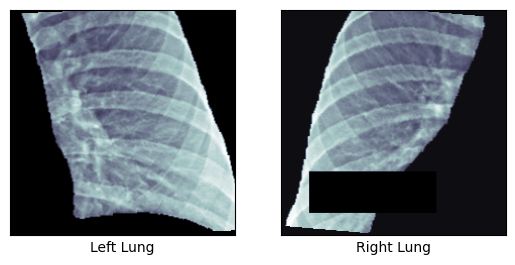

In [12]:
# Test the dataset
dataset_path = "../split_node21/lung_seg/train/"

# Load with default settings
dataloader = load_image_pair_dataset(
    dataset_path=dataset_path,
    batch_size=8,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = False,
    transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

# Test loading a batch
for batch_idx, (lungl, lungr, class_idx, path1, path2) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  lungl shape: {lungl.shape}")
    print(f"  lungr shape: {lungr.shape}")
    print(f"  Class indices: {class_idx}")
    print(f"  Sample paths: {path1[0]}, {path2[0]}")
    if batch_idx == 0:  # Just show first batch
        break

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.setp(ax.get_xticklabels(),visible=(False))
plt.setp(ax.get_yticklabels(),visible=(False))
ax.imshow(lungl[0][0],cmap="bone")
ax.set_xlabel('Left Lung')
ax.tick_params(axis='both', which='both', length=0)

ax2 = fig.add_subplot(1,2,2)
plt.setp(ax2.get_xticklabels(),visible=(False))
plt.setp(ax2.get_yticklabels(),visible=(False))
# ax2.imshow(np.flip(lung_r, axis=1),cmap="bone")
ax2.imshow(lungr[0][0],cmap="bone")

ax2.set_xlabel('Right Lung')
ax2.tick_params(axis='both', which='both', length=0)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 29.34it/s]


Total pairs: 2581
Number of classes: 2
Class mapping: {'nodule': 0, 'normal': 1}

Pairs per class:
  nodule (idx=0): 742
  normal (idx=1): 1839
Batch 0:
  lungl shape: torch.Size([8, 3, 224, 224])
  lungr shape: torch.Size([8, 3, 224, 224])
  Class indices: tensor([0, 1, 0, 1, 0, 0, 0, 1])
  Sample paths: ../split_node21/lung_seg/train/nodule/n0165/lung_l.png, ../split_node21/lung_seg/train/nodule/n0165/lung_r.png


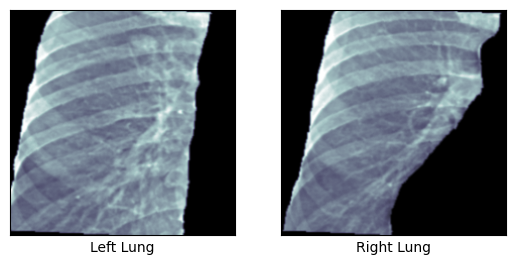

In [13]:
# Test the dataset
dataset_path = "../split_node21/lung_seg/train/"

# Load with default settings
dataloader = load_image_pair_dataset(
    dataset_path=dataset_path,
    batch_size=8,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

# Test loading a batch
for batch_idx, (lungl, lungr, class_idx, path1, path2) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  lungl shape: {lungl.shape}")
    print(f"  lungr shape: {lungr.shape}")
    print(f"  Class indices: {class_idx}")
    print(f"  Sample paths: {path1[0]}, {path2[0]}")
    if batch_idx == 0:  # Just show first batch
        break

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.setp(ax.get_xticklabels(),visible=(False))
plt.setp(ax.get_yticklabels(),visible=(False))
ax.imshow(lungl[0][0],cmap="bone")
ax.set_xlabel('Left Lung')
ax.tick_params(axis='both', which='both', length=0)

ax2 = fig.add_subplot(1,2,2)
plt.setp(ax2.get_xticklabels(),visible=(False))
plt.setp(ax2.get_yticklabels(),visible=(False))
# ax2.imshow(np.flip(lung_r, axis=1),cmap="bone")
ax2.imshow(lungr[0][0],cmap="bone")

ax2.set_xlabel('Right Lung')
ax2.tick_params(axis='both', which='both', length=0)

## Pass through images

In [14]:
# Freeze the Models
for param in rgb_model.parameters():
    param.requires_grad = False

for param in grey_model.parameters():
    param.requires_grad = False

for param in single_model.parameters():
    param.requires_grad = False

for param in model2_comparable.parameters():
    param.requires_grad = False

In [15]:
# move to GPU
device = helpers.models.get_device()
rgb_model.to(device)
grey_model.to(device)
model2_comparable.to(device)
single_model.to(device)
print(device)

cuda


In [16]:
from sklearn.feature_selection import mutual_info_regression

def mutual_information_sklearn(vec1, vec2):
    """
    Compute MI using sklearn's mutual_info_regression
    Treats one vector as features, other as target
    """
    # Reshape for sklearn
    X = vec1.reshape(-1, 1)
    y = vec2
    
    # Use sklearn's MI estimator
    mi_score = mutual_info_regression(X, y, random_state=42)[0]
    return mi_score

In [17]:
# Test the dataset
dataset_path = "../split_node21/arch_seg/"#"../legacy_split_node21"

# Load with default settings
train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [18]:
# Load with default settings
single_train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 28.70it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [19]:
# Load with default settings
test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [20]:
# Load with default settings
single_test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 73.01it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [21]:
import torch.nn.functional as F

for (lungl, lungr, class_idx, path1, path2) in test_dataloader:
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,5):
        img = path1[i].split("/")[-2]
        print(f"image: {img}")        
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        print("Class: Normal" if class_idx[i].item()==0 else "Class: Nodule")
        print("              RGB   Rad   Grey")
        print(f"Cosine:      {np.round(rgb_cosine_sim.item(), 2)}   {np.round(rad_cosine_sim.item(), 2)}   {np.round(grey_cosine_sim.item(), 2)}")
        print(f"Euclid min:  {np.round(rgb_euclidean_dist.squeeze().min().item(), 2)}   {np.round(rad_euclidean_dist.squeeze().min().item(), 2)}   {np.round(grey_euclidean_dist.squeeze().min().item(), 2)}")
        print(f"Euclid max:  {np.round(rgb_euclidean_dist.squeeze().max().item(), 2)}   {np.round(rad_euclidean_dist.squeeze().max().item(), 2)}   {np.round(grey_euclidean_dist.squeeze().max().item(), 2)}")
        print(f"Manhat min:  {np.round(rgb_manhattan_dist.squeeze().min().item(), 2)}   {np.round(rad_manhattan_dist.squeeze().min().item(), 2)}   {np.round(grey_manhattan_dist.squeeze().min().item(), 2)}")
        print(f"Manhat max:  {np.round(rgb_manhattan_dist.squeeze().max().item(), 2)}   {np.round(rad_manhattan_dist.squeeze().max().item(), 2)}   {np.round(grey_manhattan_dist.squeeze().max().item(), 2)}")
        print(f"Mutual info: {np.round(rgb_mutual_info, 2)}   {np.round(rad_mutual_info, 2)}   {np.round(grey_mutual_info, 2)}")
        print("===================================================")
    break

image: n0578
Class: Nodule
              RGB   Rad   Grey
Cosine:      1.0   0.99   1.0
Euclid min:  0.0   0.0   0.0
Euclid max:  0.15   0.26   0.18
Manhat min:  0.0   0.0   0.0
Manhat max:  0.15   0.26   0.18
Mutual info: 1.34   0.61   1.18
image: c1422
Class: Normal
              RGB   Rad   Grey
Cosine:      1.0   0.99   1.0
Euclid min:  0.0   0.0   0.0
Euclid max:  0.17   0.27   0.16
Manhat min:  0.0   0.0   0.0
Manhat max:  0.17   0.27   0.16
Mutual info: 1.41   0.62   1.21
image: c1123
Class: Normal
              RGB   Rad   Grey
Cosine:      1.0   0.99   1.0
Euclid min:  0.0   0.0   0.0
Euclid max:  0.16   0.27   0.22
Manhat min:  0.0   0.0   0.0
Manhat max:  0.16   0.27   0.22
Mutual info: 1.37   0.73   1.25
image: c0028
Class: Normal
              RGB   Rad   Grey
Cosine:      1.0   0.99   1.0
Euclid min:  0.0   0.0   0.0
Euclid max:  0.18   0.27   0.14
Manhat min:  0.0   0.0   0.0
Manhat max:  0.18   0.27   0.14
Mutual info: 1.46   0.65   1.22
image: c3835
Class: Normal
     

In [75]:
import torch.nn.functional as F

for (lungl, lungr, class_idx, path1, path2) in single_test_dataloader:
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,5):
        img = path1[i].split("/")[-2]
        print(f"image: {img}")        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        print("Class: Normal" if class_idx[i].item()==0 else "Class: Nodule")
        print("              Single")
        print(f"Cosine:      {np.round(single_cosine_sim.item(), 2)}")
        print(f"Euclid min:  {np.round(single_euclidean_dist.squeeze().min().item(), 2)}   ")
        print(f"Euclid max:  {np.round(single_euclidean_dist.squeeze().max().item(), 2)}   ")
        print(f"Manhat min:  {np.round(single_manhattan_dist.squeeze().min().item(), 2)}   ")
        print(f"Manhat max:  {np.round(single_manhattan_dist.squeeze().max().item(), 2)}   ")
        print(f"Mutual info: {np.round(single_mutual_info, 2)}   ")
        print("===================================================")
    break

image: n0412
Class: Nodule
              Single
Cosine:      0.93
Euclid min:  0.0   
Euclid max:  0.15   
Manhat min:  0.0   
Manhat max:  0.15   
Mutual info: 1.22   
image: c0518
Class: Normal
              Single
Cosine:      0.93
Euclid min:  0.0   
Euclid max:  0.13   
Manhat min:  0.0   
Manhat max:  0.13   
Mutual info: 1.29   
image: n0958
Class: Nodule
              Single
Cosine:      0.93
Euclid min:  0.0   
Euclid max:  0.15   
Manhat min:  0.0   
Manhat max:  0.15   
Mutual info: 1.23   
image: c0018
Class: Normal
              Single
Cosine:      0.93
Euclid min:  0.0   
Euclid max:  0.2   
Manhat min:  0.0   
Manhat max:  0.2   
Mutual info: 1.22   
image: c1195
Class: Normal
              Single
Cosine:      0.93
Euclid min:  0.0   
Euclid max:  0.21   
Manhat min:  0.0   
Manhat max:  0.21   
Mutual info: 1.2   


In [32]:
from sklearn.feature_selection import mutual_info_regression

def mutual_information_sklearn(vec1, vec2):
    """
    Compute MI using sklearn's mutual_info_regression
    Treats one vector as features, other as target
    """
    # Reshape for sklearn
    X = vec1.reshape(-1, 1)
    y = vec2
    
    # Use sklearn's MI estimator
    mi_score = mutual_info_regression(X, y, random_state=42)[0]
    return mi_score

### Arch Images

In [33]:
# Test the dataset
dataset_path = "../split_node21/arch_seg/"#"../legacy_split_node21"

# Load with default settings
train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [34]:
# Load with default settings
test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [37]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
for (lungl, lungr, class_idx, path1, path2) in test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "test",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
df = pd.DataFrame(results)
df.to_csv('arch_raw_network_similarity_metrics.csv', index=False)

In [38]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in single_train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
for (lungl, lungr, class_idx, path1, path2) in single_test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
single_df = pd.DataFrame(results)

In [39]:
df = pd.read_csv('arch_raw_network_similarity_metrics.csv') 

In [40]:
merged_df = df.merge(single_df[['img','single_cosine_sim', 'single_euclidean_max', 'single_euclidean_mean', 'single_euclidean_min',
       'single_manhattan_max', 'single_manhattan_mean', 'single_manhattan_min', 'single_mutual_info']],on="img", how='left',)

In [41]:
merged_df.head()

class    img distribution  rgb_cosine_sim  rad_cosine_sim  \
0  Nodule  n0226        train             1.0            0.99   
1  Normal  c2690        train             1.0            0.99   
2  Nodule  n0875        train             1.0            0.99   
3  Nodule  n0757        train             1.0            0.99   
4  Normal  c0433        train             1.0            0.99   

   grey_cosine_sim  rgb_euclidean_min  rad_euclidean_min  grey_euclidean_min  \
0              1.0                0.0                0.0                 0.0   
1              1.0                0.0                0.0                 0.0   
2              1.0                0.0                0.0                 0.0   
3              1.0                0.0                0.0                 0.0   
4              1.0                0.0                0.0                 0.0   

   rgb_euclidean_mean  ...  rad_mutual_info  grey_mutual_info  \
0                0.02  ...             0.59              1.21   
1                0.02  ...             0.58              1.22   
2                0.02  ...             0.56              1.12   
3                0.02  ...             0.58              1.22   
4                0.02  ...             0.68              1.25   

   single_cosine_sim  single_euclidean_max  single_euclidean_mean  \
0               0.93                  0.16                   0.03   
1               0.93                  0.15                   0.03   
2               0.93                  0.15                   0.03   
3               0.93                  0.13                   0.03   
4               0.93                  0.15                   0.02   

   single_euclidean_min  single_manhattan_max  single_manhattan_mean  \
0                   0.0                  0.16                   0.03   
1                   0.0                  0.15                   0.03   
2                   0.0                  0.15                   0.03   
3                   0.0                  0.13                   0.03   
4                   0.0                  0.15                   0.02   

   single_manhattan_min  single_mutual_info  
0                   0.0                1.23  
1                   0.0                1.22  
2                   0.0                1.18  
3                   0.0                1.21  
4                   0.0                1.23  

[5 rows x 35 columns]

In [42]:
len(merged_df)

3688

In [43]:
merged_df.columns[3:]

Index(['rgb_cosine_sim', 'rad_cosine_sim', 'grey_cosine_sim',
       'rgb_euclidean_min', 'rad_euclidean_min', 'grey_euclidean_min',
       'rgb_euclidean_mean', 'rad_euclidean_mean', 'grey_euclidean_mean',
       'rgb_euclidean_max', 'rad_euclidean_max', 'grey_euclidean_max',
       'rgb_manhattan_min', 'rad_manhattan_min', 'grey_manhattan_min',
       'rgb_manhattan_mean', 'rad_manhattan_mean', 'grey_manhattan_mean',
       'rgb_manhattan_max', 'rad_manhattan_max', 'grey_manhattan_max',
       'rgb_mutual_info', 'rad_mutual_info', 'grey_mutual_info',
       'single_cosine_sim', 'single_euclidean_max', 'single_euclidean_mean',
       'single_euclidean_min', 'single_manhattan_max', 'single_manhattan_mean',
       'single_manhattan_min', 'single_mutual_info'],
      dtype='object')

In [44]:
merged_df.groupby(['class'])[merged_df.columns[3:]].mean()

rgb_cosine_sim  rad_cosine_sim  grey_cosine_sim  rgb_euclidean_min  \
class                                                                        
Nodule             1.0        0.989981              1.0                0.0   
Normal             1.0        0.989966              1.0                0.0   

        rad_euclidean_min  grey_euclidean_min  rgb_euclidean_mean  \
class                                                               
Nodule                0.0                 0.0            0.021160   
Normal                0.0                 0.0            0.021248   

        rad_euclidean_mean  grey_euclidean_mean  rgb_euclidean_max  ...  \
class                                                               ...   
Nodule            0.063981             0.030000           0.158245  ...   
Normal            0.063512             0.029989           0.159243  ...   

        rad_mutual_info  grey_mutual_info  single_cosine_sim  \
class                                                          
Nodule         0.622736          1.217302               0.93   
Normal         0.627808          1.218018               0.93   

        single_euclidean_max  single_euclidean_mean  single_euclidean_min  \
class                                                                       
Nodule              0.156453               0.025670                   0.0   
Normal              0.155776               0.025685                   0.0   

        single_manhattan_max  single_manhattan_mean  single_manhattan_min  \
class                                                                       
Nodule              0.156453               0.025670                   0.0   
Normal              0.155776               0.025685                   0.0   

        single_mutual_info  
class                       
Nodule            1.237821  
Normal            1.236762  

[2 rows x 32 columns]

In [45]:
merged_df.to_csv('merged_arch_raw_network_similarity_metrics.csv', index=False)

### Lung Seg Images

In [46]:
# Test the dataset
dataset_path = "../split_node21/lung_seg/"#"../legacy_split_node21"

# Load with default settings
train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [47]:
# Test the dataset
dataset_path = "../split_node21/lung_seg/"#"../legacy_split_node21"

# Load with default settings
single_train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 30.36it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [48]:
# Load with default settings
test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [49]:
# Load with default settings
single_test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 69.21it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [50]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
for (lungl, lungr, class_idx, path1, path2) in test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "test",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
df = pd.DataFrame(results)
df.to_csv('lungseg_raw_network_similarity_metrics.csv', index=False)

In [51]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in single_train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
for (lungl, lungr, class_idx, path1, path2) in single_test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
single_df = pd.DataFrame(results)

In [52]:
df = pd.read_csv('lungseg_raw_network_similarity_metrics.csv') 

In [53]:
merged_df = df.merge(single_df[['img','single_cosine_sim', 'single_euclidean_max', 'single_euclidean_min','single_euclidean_mean',
       'single_manhattan_max', 'single_manhattan_min','single_manhattan_mean', 'single_mutual_info']],on="img", how='left',)

In [54]:
merged_df.head()

class    img distribution  rgb_cosine_sim  rad_cosine_sim  \
0  Nodule  n0222        train             1.0            0.99   
1  Nodule  n0534        train             1.0            0.99   
2  Nodule  n0322        train             1.0            0.99   
3  Normal  c2052        train             1.0            0.99   
4  Normal  c3106        train             1.0            0.99   

   grey_cosine_sim  rgb_euclidean_min  rad_euclidean_min  grey_euclidean_min  \
0              1.0                0.0                0.0                 0.0   
1              1.0                0.0                0.0                 0.0   
2              1.0                0.0                0.0                 0.0   
3              1.0                0.0                0.0                 0.0   
4              1.0                0.0                0.0                 0.0   

   rgb_euclidean_mean  ...  rad_mutual_info  grey_mutual_info  \
0                0.02  ...             0.65              1.25   
1                0.02  ...             0.59              1.23   
2                0.02  ...             0.67              1.33   
3                0.02  ...             0.59              1.24   
4                0.02  ...             0.62              1.24   

   single_cosine_sim  single_euclidean_max  single_euclidean_min  \
0               0.93                  0.12                   0.0   
1               0.93                  0.19                   0.0   
2               0.93                  0.18                   0.0   
3               0.93                  0.15                   0.0   
4               0.93                  0.15                   0.0   

   single_euclidean_mean  single_manhattan_max  single_manhattan_min  \
0                   0.02                  0.12                   0.0   
1                   0.02                  0.19                   0.0   
2                   0.02                  0.18                   0.0   
3                   0.02                  0.15                   0.0   
4                   0.02                  0.15                   0.0   

   single_manhattan_mean  single_mutual_info  
0                   0.02                1.30  
1                   0.02                1.25  
2                   0.02                1.32  
3                   0.02                1.26  
4                   0.02                1.22  

[5 rows x 35 columns]

In [55]:
len(merged_df)

3688

In [56]:
merged_df.columns[3:]

Index(['rgb_cosine_sim', 'rad_cosine_sim', 'grey_cosine_sim',
       'rgb_euclidean_min', 'rad_euclidean_min', 'grey_euclidean_min',
       'rgb_euclidean_mean', 'rad_euclidean_mean', 'grey_euclidean_mean',
       'rgb_euclidean_max', 'rad_euclidean_max', 'grey_euclidean_max',
       'rgb_manhattan_min', 'rad_manhattan_min', 'grey_manhattan_min',
       'rgb_manhattan_mean', 'rad_manhattan_mean', 'grey_manhattan_mean',
       'rgb_manhattan_max', 'rad_manhattan_max', 'grey_manhattan_max',
       'rgb_mutual_info', 'rad_mutual_info', 'grey_mutual_info',
       'single_cosine_sim', 'single_euclidean_max', 'single_euclidean_min',
       'single_euclidean_mean', 'single_manhattan_max', 'single_manhattan_min',
       'single_manhattan_mean', 'single_mutual_info'],
      dtype='object')

In [57]:
merged_df.groupby(['class'])[merged_df.columns[3:]].mean()

rgb_cosine_sim  rad_cosine_sim  grey_cosine_sim  rgb_euclidean_min  \
class                                                                        
Nodule             1.0        0.989840         0.999991                0.0   
Normal             1.0        0.989882         1.000000                0.0   

        rad_euclidean_min  grey_euclidean_min  rgb_euclidean_mean  \
class                                                               
Nodule                0.0                 0.0            0.020340   
Normal                0.0                 0.0            0.020419   

        rad_euclidean_mean  grey_euclidean_mean  rgb_euclidean_max  ...  \
class                                                               ...   
Nodule            0.065396             0.029943           0.156217  ...   
Normal            0.064745             0.029920           0.154962  ...   

        rad_mutual_info  grey_mutual_info  single_cosine_sim  \
class                                                          
Nodule         0.594962          1.239491               0.93   
Normal         0.600316          1.242504               0.93   

        single_euclidean_max  single_euclidean_min  single_euclidean_mean  \
class                                                                       
Nodule              0.153613                   0.0               0.024566   
Normal              0.152412                   0.0               0.024509   

        single_manhattan_max  single_manhattan_min  single_manhattan_mean  \
class                                                                       
Nodule              0.153613                   0.0               0.024566   
Normal              0.152412                   0.0               0.024509   

        single_mutual_info  
class                       
Nodule            1.251198  
Normal            1.255350  

[2 rows x 32 columns]

In [58]:
merged_df.to_csv('merged_lungseg_raw_network_similarity_metrics.csv', index=False)

### Crop Images

In [59]:
# Test the dataset
dataset_path = "../split_node21/crop"#"../legacy_split_node21"

# Load with default settings
train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [60]:
# Test the dataset
dataset_path = "../split_node21/crop"#"../legacy_split_node21"

# Load with default settings
single_train_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"train"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 28.88it/s]

Total pairs: 2581
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 742
  normal (idx=0): 1839


In [61]:
# Load with default settings
test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [62]:
# Load with default settings
single_test_dataloader = load_image_pair_dataset(
    dataset_path=os.path.join(dataset_path,"test"),
    class_to_idx={'normal': 0, 'nodule':1},
    batch_size=200,
    crop_size=224,  # Standard ResNet50 input size,
    symmetrical_transforms = True,
    single=True
    # transform = transforms.Compose(randomaugs+[get_cxr_dataset_normalisation("cxr14","arch")])
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 71.16it/s]

Total pairs: 1107
Number of classes: 2
Class mapping: {'normal': 0, 'nodule': 1}

Pairs per class:
  nodule (idx=1): 318
  normal (idx=0): 789


In [63]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
for (lungl, lungr, class_idx, path1, path2) in test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]
        rgb_lungl = rgb_model(lungl[i:i+1])
        rgb_lungr = rgb_model(lungr[i:i+1])
        grey_lungl = grey_model(lungl[i:i+1])
        grey_lungr = grey_model(lungr[i:i+1])
        # single_lungl = single_model(lungl[i:i+1])
        # single_lungr = single_model(lungr[i:i+1])
        rad_lungl = model2_backbone(lungl[i:i+1])
        rad_lungr = model2_backbone(lungr[i:i+1])
        
        rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
        rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
        grey_cosine_sim = F.cosine_similarity(grey_lungl, grey_lungr, dim=1)
        # single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        
        rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
        rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
        grey_euclidean_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=2)
        # single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        
        rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)
        rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)
        grey_manhattan_dist = F.pairwise_distance(grey_lungl, grey_lungr, p=1)
        # single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
    
        rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze().cpu(), rgb_lungr.squeeze().cpu())
        rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze().cpu(), rad_lungr.squeeze().cpu())
        grey_mutual_info = mutual_information_sklearn(grey_lungl.squeeze().cpu(), grey_lungr.squeeze().cpu())
        # single_mutual_info = mutual_information_sklearn(single_lungl.squeeze(), single_lungr.squeeze())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "test",
            'rgb_cosine_sim': np.round(rgb_cosine_sim.item(), 2),
            'rad_cosine_sim': np.round(rad_cosine_sim.item(), 2),
            'grey_cosine_sim': np.round(grey_cosine_sim.item(), 2),
            'rgb_euclidean_min': np.round(rgb_euclidean_dist.squeeze().min().item(), 2),
            'rad_euclidean_min': np.round(rad_euclidean_dist.squeeze().min().item(), 2),
            'grey_euclidean_min': np.round(grey_euclidean_dist.squeeze().min().item(), 2),
            'rgb_euclidean_mean': np.round(rgb_euclidean_dist.squeeze().mean().item(), 2),
            'rad_euclidean_mean': np.round(rad_euclidean_dist.squeeze().mean().item(), 2),
            'grey_euclidean_mean': np.round(grey_euclidean_dist.squeeze().mean().item(), 2),
            'rgb_euclidean_max': np.round(rgb_euclidean_dist.squeeze().max().item(), 2),
            'rad_euclidean_max': np.round(rad_euclidean_dist.squeeze().max().item(), 2),
            'grey_euclidean_max': np.round(grey_euclidean_dist.squeeze().max().item(), 2),
            'rgb_manhattan_min': np.round(rgb_manhattan_dist.squeeze().min().item(), 2),
            'rad_manhattan_min': np.round(rad_manhattan_dist.squeeze().min().item(), 2),
            'grey_manhattan_min': np.round(grey_manhattan_dist.squeeze().min().item(), 2),
            'rgb_manhattan_mean': np.round(rgb_manhattan_dist.squeeze().mean().item(), 2),
            'rad_manhattan_mean': np.round(rad_manhattan_dist.squeeze().mean().item(), 2),
            'grey_manhattan_mean': np.round(grey_manhattan_dist.squeeze().mean().item(), 2),
            'rgb_manhattan_max': np.round(rgb_manhattan_dist.squeeze().max().item(), 2),
            'rad_manhattan_max': np.round(rad_manhattan_dist.squeeze().max().item(), 2),
            'grey_manhattan_max': np.round(grey_manhattan_dist.squeeze().max().item(), 2),
            'rgb_mutual_info': np.round(rgb_mutual_info, 2),
            'rad_mutual_info': np.round(rad_mutual_info, 2),
            'grey_mutual_info': np.round(grey_mutual_info, 2)
        })
df = pd.DataFrame(results)
df.to_csv('crop_raw_network_similarity_metrics.csv', index=False)

In [64]:
import torch.nn.functional as F
import pandas as pd
results = []

for (lungl, lungr, class_idx, path1, path2) in single_train_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
for (lungl, lungr, class_idx, path1, path2) in single_test_dataloader:
    # move to GPU
    lungl = lungl.to(device)
    lungr = lungr.to(device)

    for i in range(0,len(class_idx)):
        img = path1[i].split("/")[-2]      
        
        single_lungl = single_model(lungl[i:i+1])
        single_lungr = single_model(lungr[i:i+1])
        single_cosine_sim = F.cosine_similarity(single_lungl, rad_lungr, dim=1)
        single_euclidean_dist = F.pairwise_distance(single_lungl, single_lungr, p=2)
        single_manhattan_dist = F.pairwise_distance(single_lungl, single_lungr, p=1)
        single_mutual_info = mutual_information_sklearn(single_lungl.squeeze().cpu(), single_lungr.squeeze().cpu())
        
        class_label = "Normal" if class_idx[i].item() == 0 else "Nodule"
    
        # Append row data to results list
        results.append({
            'class': class_label,
            'img': img,
            'distribution': "train",
            'single_cosine_sim': np.round(single_cosine_sim.item(), 2),
            'single_euclidean_min': np.round(single_euclidean_dist.squeeze().min().item(), 2),
            'single_euclidean_mean': np.round(single_euclidean_dist.squeeze().mean().item(), 2),
            'single_euclidean_max': np.round(single_euclidean_dist.squeeze().max().item(), 2),
            'single_manhattan_min': np.round(single_manhattan_dist.squeeze().min().item(), 2),
            'single_manhattan_mean': np.round(single_manhattan_dist.squeeze().mean().item(), 2),
            'single_manhattan_max': np.round(single_manhattan_dist.squeeze().max().item(), 2),
            'single_mutual_info': np.round(single_mutual_info, 2),
        })
single_df = pd.DataFrame(results)

In [65]:
df = pd.read_csv('crop_raw_network_similarity_metrics.csv') 

In [66]:
merged_df = df.merge(single_df[['img','single_cosine_sim', 'single_euclidean_max', 'single_euclidean_mean','single_euclidean_min',
       'single_manhattan_max', 'single_manhattan_mean', 'single_manhattan_min', 'single_mutual_info']],on="img", how='left',)

In [67]:
merged_df.head()

class    img distribution  rgb_cosine_sim  rad_cosine_sim  \
0  Normal  c2581        train             1.0            0.99   
1  Normal  c2488        train             1.0            0.99   
2  Nodule  n0600        train             1.0            0.99   
3  Normal  c0805        train             1.0            0.99   
4  Normal  c0346        train             1.0            0.99   

   grey_cosine_sim  rgb_euclidean_min  rad_euclidean_min  grey_euclidean_min  \
0              1.0                0.0                0.0                 0.0   
1              1.0                0.0                0.0                 0.0   
2              1.0                0.0                0.0                 0.0   
3              1.0                0.0                0.0                 0.0   
4              1.0                0.0                0.0                 0.0   

   rgb_euclidean_mean  ...  rad_mutual_info  grey_mutual_info  \
0                0.03  ...             0.59              1.20   
1                0.02  ...             0.64              1.22   
2                0.02  ...             0.74              1.20   
3                0.03  ...             0.60              1.16   
4                0.02  ...             0.64              1.20   

   single_cosine_sim  single_euclidean_max  single_euclidean_mean  \
0               0.93                  0.18                   0.02   
1               0.93                  0.15                   0.02   
2               0.93                  0.16                   0.03   
3               0.93                  0.15                   0.03   
4               0.93                  0.14                   0.02   

   single_euclidean_min  single_manhattan_max  single_manhattan_mean  \
0                   0.0                  0.18                   0.02   
1                   0.0                  0.15                   0.02   
2                   0.0                  0.16                   0.03   
3                   0.0                  0.15                   0.03   
4                   0.0                  0.14                   0.02   

   single_manhattan_min  single_mutual_info  
0                   0.0                1.25  
1                   0.0                1.25  
2                   0.0                1.17  
3                   0.0                1.22  
4                   0.0                1.22  

[5 rows x 35 columns]

In [68]:
len(merged_df)

3688

In [69]:
merged_df.columns[3:]

Index(['rgb_cosine_sim', 'rad_cosine_sim', 'grey_cosine_sim',
       'rgb_euclidean_min', 'rad_euclidean_min', 'grey_euclidean_min',
       'rgb_euclidean_mean', 'rad_euclidean_mean', 'grey_euclidean_mean',
       'rgb_euclidean_max', 'rad_euclidean_max', 'grey_euclidean_max',
       'rgb_manhattan_min', 'rad_manhattan_min', 'grey_manhattan_min',
       'rgb_manhattan_mean', 'rad_manhattan_mean', 'grey_manhattan_mean',
       'rgb_manhattan_max', 'rad_manhattan_max', 'grey_manhattan_max',
       'rgb_mutual_info', 'rad_mutual_info', 'grey_mutual_info',
       'single_cosine_sim', 'single_euclidean_max', 'single_euclidean_mean',
       'single_euclidean_min', 'single_manhattan_max', 'single_manhattan_mean',
       'single_manhattan_min', 'single_mutual_info'],
      dtype='object')

In [70]:
merged_df.groupby(['class'])[merged_df.columns[3:]].mean()

rgb_cosine_sim  rad_cosine_sim  grey_cosine_sim  rgb_euclidean_min  \
class                                                                        
Nodule             1.0        0.989972              1.0                0.0   
Normal             1.0        0.989954              1.0                0.0   

        rad_euclidean_min  grey_euclidean_min  rgb_euclidean_mean  \
class                                                               
Nodule                0.0                 0.0            0.023462   
Normal                0.0                 0.0            0.023333   

        rad_euclidean_mean  grey_euclidean_mean  rgb_euclidean_max  ...  \
class                                                               ...   
Nodule            0.065462             0.030000           0.159028  ...   
Normal            0.065601             0.030004           0.159467  ...   

        rad_mutual_info  grey_mutual_info  single_cosine_sim  \
class                                                          
Nodule         0.616151          1.195208               0.93   
Normal         0.619688          1.195274               0.93   

        single_euclidean_max  single_euclidean_mean  single_euclidean_min  \
class                                                                       
Nodule              0.156462               0.029151                   0.0   
Normal              0.155613               0.028843                   0.0   

        single_manhattan_max  single_manhattan_mean  single_manhattan_min  \
class                                                                       
Nodule              0.156462               0.029151                   0.0   
Normal              0.155613               0.028843                   0.0   

        single_mutual_info  
class                       
Nodule            1.212047  
Normal            1.214768  

[2 rows x 32 columns]

In [71]:
merged_df.to_csv('merged_crop_raw_network_similarity_metrics.csv', index=False)

## Analysis of Results

### Analysis Methods

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, levene
import warnings
warnings.filterwarnings('ignore')


In [115]:
def analyze_distance_metrics(df):
    """
    Comprehensive analysis of distance/similarity metrics by class
    """
    # Get metric columns (exclude class)
    metric_cols = [col for col in df.columns if col != 'class']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Overview comparison - Box plots for all metrics
    plt.subplot(4, 4, 1)
    df_melted = df.melt(id_vars=['class'], value_vars=metric_cols, 
                       var_name='Metric', value_name='Value')
    sns.boxplot(data=df_melted, x='Metric', y='Value', hue='class')
    plt.xticks(rotation=90, fontsize=8)
    plt.title('Distribution of All Metrics by Class')
    plt.legend(title='Class')
    
    # 2. Mean comparison bar chart
    plt.subplot(4, 4, 2)
    means_by_class = df.groupby('class')[metric_cols].mean()
    means_by_class.T.plot(kind='bar', ax=plt.gca())
    plt.title('Mean Scores by Class')
    plt.xticks(rotation=90, fontsize=8)
    plt.legend(title='Class')
    
    # 3. Difference plot (assuming class 0 vs class 1)
    plt.subplot(4, 4, 3)
    if len(df['class'].unique()) == 2:
        differences = means_by_class.iloc[0] - means_by_class.iloc[1]
        colors = ['red' if x < 0 else 'green' for x in differences]
        differences.plot(kind='bar', color=colors)
        plt.title('Difference in Means (Class 0 - Class 1)')
        plt.xticks(rotation=90, fontsize=8)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 4. Color space comparison - Cosine similarities
    plt.subplot(4, 4, 4)
    cosine_cols = [col for col in metric_cols if 'cosine' in col]
    if cosine_cols:
        cosine_data = df.melt(id_vars=['class'], value_vars=cosine_cols, 
                             var_name='Metric', value_name='Value')
        sns.boxplot(data=cosine_data, x='Metric', y='Value', hue='class')
        plt.xticks(rotation=45, fontsize=8)
        plt.title('Cosine Similarities by Color Space')
    
    # 5. Euclidean distances comparison
    plt.subplot(4, 4, 5)
    euclidean_cols = [col for col in metric_cols if 'euclidean' in col]
    if euclidean_cols:
        euclidean_data = df.melt(id_vars=['class'], value_vars=euclidean_cols, 
                                var_name='Metric', value_name='Value')
        sns.boxplot(data=euclidean_data, x='Metric', y='Value', hue='class')
        plt.xticks(rotation=45, fontsize=8)
        plt.title('Euclidean Distances by Color Space')
    
    # 6. Manhattan distances comparison
    plt.subplot(4, 4, 6)
    manhattan_cols = [col for col in metric_cols if 'manhattan' in col]
    if manhattan_cols:
        manhattan_data = df.melt(id_vars=['class'], value_vars=manhattan_cols, 
                                var_name='Metric', value_name='Value')
        sns.boxplot(data=manhattan_data, x='Metric', y='Value', hue='class')
        plt.xticks(rotation=45, fontsize=8)
        plt.title('Manhattan Distances by Color Space')
    
    # 7. Mutual Information comparison
    plt.subplot(4, 4, 7)
    mi_cols = [col for col in metric_cols if 'mutual_info' in col]
    if mi_cols:
        mi_data = df.melt(id_vars=['class'], value_vars=mi_cols, 
                         var_name='Metric', value_name='Value')
        sns.boxplot(data=mi_data, x='Metric', y='Value', hue='class')
        plt.xticks(rotation=45, fontsize=8)
        plt.title('Mutual Information by Color Space')
    
    # 8. Color space comparison - RGB vs RAD vs Grey
    plt.subplot(4, 4, 8)
    # Compare same metric across color spaces
    if 'rgb_cosine_sim' in df.columns and 'rad_cosine_sim' in df.columns and 'grey_cosine_sim' in df.columns:
        color_comparison = df[['class', 'rgb_cosine_sim', 'rad_cosine_sim', 'grey_cosine_sim']]
        color_melted = color_comparison.melt(id_vars=['class'], var_name='Color_Space', value_name='Cosine_Sim')
        sns.boxplot(data=color_melted, x='Color_Space', y='Cosine_Sim', hue='class')
        plt.title('Cosine Similarity Across Color Spaces')
    
    # 9-12. Individual metric distributions for key metrics
    # key_metrics = ['rgb_cosine_sim', 'rgb_mutual_info', 'rgb_euclidean_min', 'rad_cosine_sim']
    key_metrics = ['rgb_mutual_info', 'grey_mutual_info', 'rad_mutual_info', 'rad_cosine_sim']
    available_key_metrics = [m for m in key_metrics if m in df.columns]
    
    for i, metric in enumerate(available_key_metrics[:4]):
        plt.subplot(4, 4, 9 + i)
        for class_val in sorted(df['class'].unique()):
            class_data = df[df['class'] == class_val][metric]
            plt.hist(class_data, alpha=0.7, bins=20, 
                    label=f'Class {class_val}', edgecolor='black')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.title(f'{metric} Distribution')
        plt.legend()
    
    # 13. Correlation heatmap
    plt.subplot(4, 4, 13)
    correlation_matrix = df[metric_cols].corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
                square=False, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Between All Metrics')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    # 14. Effect sizes visualization
    plt.subplot(4, 4, 14)
    if len(df['class'].unique()) == 2:
        effect_sizes = []
        metric_names = []
        
        for metric in metric_cols:
            class_0_data = df[df['class'] == 0][metric]
            class_1_data = df[df['class'] == 1][metric]
            
            # Calculate Cohen's d
            pooled_std = np.sqrt(((len(class_0_data) - 1) * class_0_data.std()**2 + 
                                 (len(class_1_data) - 1) * class_1_data.std()**2) / 
                                (len(class_0_data) + len(class_1_data) - 2))
            
            if pooled_std > 0:
                cohens_d = (class_0_data.mean() - class_1_data.mean()) / pooled_std
                effect_sizes.append(cohens_d)
                metric_names.append(metric)
        
        colors = ['red' if x < 0 else 'green' for x in effect_sizes]
        plt.barh(range(len(metric_names)), effect_sizes, color=colors)
        plt.yticks(range(len(metric_names)), metric_names, fontsize=8)
        plt.xlabel("Cohen's d (Effect Size)")
        plt.title('Effect Sizes (Class 0 vs Class 1)')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # 15. Distance metric comparison (min vs max)
    plt.subplot(4, 4, 15)
    if 'rgb_euclidean_min' in df.columns and 'rgb_euclidean_max' in df.columns:
        min_max_data = df[['class', 'rgb_euclidean_min', 'rgb_euclidean_max']]
        min_max_melted = min_max_data.melt(id_vars=['class'], var_name='Distance_Type', value_name='Distance')
        sns.boxplot(data=min_max_melted, x='Distance_Type', y='Distance', hue='class')
        plt.title('RGB Euclidean: Min vs Max Distance')
    
    # 16. Method comparison summary
    plt.subplot(4, 4, 16)
    # Group by method type
    method_groups = {
        'Cosine': [col for col in metric_cols if 'cosine' in col],
        'Euclidean': [col for col in metric_cols if 'euclidean' in col],
        'Manhattan': [col for col in metric_cols if 'manhattan' in col],
        'Mutual_Info': [col for col in metric_cols if 'mutual_info' in col]
    }
    
    if len(df['class'].unique()) == 2:
        method_effects = {}
        for method, cols in method_groups.items():
            if cols:
                avg_effect = np.mean([
                    abs((df[df['class'] == 0][col].mean() - df[df['class'] == 1][col].mean()) / 
                        df[col].std()) for col in cols if col in df.columns
                ])
                method_effects[method] = avg_effect
        
        if method_effects:
            methods = list(method_effects.keys())
            effects = list(method_effects.values())
            plt.bar(methods, effects, color=['blue', 'orange', 'green', 'red'])
            plt.title('Average Effect Size by Method Type')
            plt.ylabel('Average Standardized Effect')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [122]:
def statistical_analysis_distances(df,single=False):
    """
    Perform comprehensive statistical tests for distance metrics
    """
    metric_cols = [col for col in df.columns if col != 'class']
    results = []
    
    print("="*100)
    print("DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS")
    print("="*100)
    
    # Group metrics by method and model type
    if single:
        metric_groups = {
            'Cosine Similarity': {
                'RGB Model': ['rgb_cosine_sim'],
                'RAD Model': ['rad_cosine_sim'], 
                'Grey Model': ['grey_cosine_sim'],
                'Single Model': ['single_cosine_sim']
            },
            'Euclidean Distance': {
                'RGB Model (Min)': ['rgb_euclidean_min'],
                'RGB Model (Max)': ['rgb_euclidean_max'],
                'RAD Model (Min)': ['rad_euclidean_min'],
                'RAD Model (Max)': ['rad_euclidean_max'],
                'Grey Model (Min)': ['grey_euclidean_min'],
                'Grey Model (Max)': ['grey_euclidean_max'],
                'Single Model (Min)': ['single_euclidean_min'],
                'Single Model (Max)': ['single_euclidean_max']
            },
            'Manhattan Distance': {
                'RGB Model (Min)': ['rgb_manhattan_min'],
                'RGB Model (Max)': ['rgb_manhattan_max'],
                'RAD Model (Min)': ['rad_manhattan_min'],
                'RAD Model (Max)': ['rad_manhattan_max'],
                'Grey Model (Min)': ['grey_manhattan_min'],
                'Grey Model (Max)': ['grey_manhattan_max'],
                'Single Model (Min)': ['single_manhattan_min'],
                'Single Model (Max)': ['single_manhattan_max']
            },
            'Mutual Information': {
                'RGB Model': ['rgb_mutual_info'],
                'RAD Model': ['rad_mutual_info'],
                'Grey Model': ['grey_mutual_info'],
                'Single Model': ['single_mutual_info']
            }
        }
    else:
        metric_groups = {
            'Cosine Similarity': {
                'RGB Model': ['rgb_cosine_sim'],
                'RAD Model': ['rad_cosine_sim'], 
                'Grey Model': ['grey_cosine_sim']
            },
            'Euclidean Distance': {
                'RGB Model (Min)': ['rgb_euclidean_min'],
                'RGB Model (Max)': ['rgb_euclidean_max'],
                'RAD Model (Min)': ['rad_euclidean_min'],
                'RAD Model (Max)': ['rad_euclidean_max'],
                'Grey Model (Min)': ['grey_euclidean_min'],
                'Grey Model (Max)': ['grey_euclidean_max']
            },
            'Manhattan Distance': {
                'RGB Model (Min)': ['rgb_manhattan_min'],
                'RGB Model (Max)': ['rgb_manhattan_max'],
                'RAD Model (Min)': ['rad_manhattan_min'],
                'RAD Model (Max)': ['rad_manhattan_max'],
                'Grey Model (Min)': ['grey_manhattan_min'],
                'Grey Model (Max)': ['grey_manhattan_max']
            },
            'Mutual Information': {
                'RGB Model': ['rgb_mutual_info'],
                'RAD Model': ['rad_mutual_info'],
                'Grey Model': ['grey_mutual_info']
            }
        }
    
    for method_name, model_groups in metric_groups.items():
        print(f"\n{'='*20} {method_name.upper()} {'='*20}")
        
        for model_name, metrics in model_groups.items():
            if metrics and metrics[0] in df.columns:
                metric = metrics[0]  # Each subgroup has one metric
                print(f"\n--- {model_name} ---")
                print(f"\n{metric.upper().replace('_', ' ')}")
                print("-" * 60)
                
                # Separate data by class
                class_0_data = df[df['class'] == 0][metric]
                class_1_data = df[df['class'] == 1][metric]
                
                # Descriptive statistics
                print(f"Class 0: Mean = {class_0_data.mean():.4f}, Std = {class_0_data.std():.4f}, N = {len(class_0_data)}")
                print(f"Class 1: Mean = {class_1_data.mean():.4f}, Std = {class_1_data.std():.4f}, N = {len(class_1_data)}")
                print(f"Difference: {class_0_data.mean() - class_1_data.mean():.4f}")
                
                # Statistical tests (same logic as before)
                if len(class_0_data) > 3 and len(class_1_data) > 3:
                    # Test for normality
                    _, p_norm_0 = stats.shapiro(class_0_data.sample(min(5000, len(class_0_data))))
                    _, p_norm_1 = stats.shapiro(class_1_data.sample(min(5000, len(class_1_data))))
                    
                    # Test for equal variances
                    _, p_levene = levene(class_0_data, class_1_data)
                    
                    # Choose appropriate test
                    if p_norm_0 > 0.05 and p_norm_1 > 0.05:
                        if p_levene > 0.05:
                            t_stat, p_value = ttest_ind(class_0_data, class_1_data)
                            test_used = "Independent t-test (equal variances)"
                        else:
                            t_stat, p_value = ttest_ind(class_0_data, class_1_data, equal_var=False)
                            test_used = "Welch's t-test (unequal variances)"
                    else:
                        u_stat, p_value = mannwhitneyu(class_0_data, class_1_data, alternative='two-sided')
                        test_used = "Mann-Whitney U test (non-parametric)"
                        t_stat = u_stat
                    
                    # Effect size
                    pooled_std = np.sqrt(((len(class_0_data) - 1) * class_0_data.std()**2 + 
                                         (len(class_1_data) - 1) * class_1_data.std()**2) / 
                                        (len(class_0_data) + len(class_1_data) - 2))
                    
                    if pooled_std > 0:
                        cohens_d = (class_0_data.mean() - class_1_data.mean()) / pooled_std
                    else:
                        cohens_d = 0
                    
                    # Effect size interpretation
                    if abs(cohens_d) < 0.2:
                        effect_interpretation = "Small"
                    elif abs(cohens_d) < 0.5:
                        effect_interpretation = "Medium"
                    elif abs(cohens_d) < 0.8:
                        effect_interpretation = "Large"
                    else:
                        effect_interpretation = "Very Large"
                    
                    print(f"\nStatistical Test: {test_used}")
                    print(f"Test Statistic: {t_stat:.4f}")
                    print(f"P-value: {p_value:.6f}")
                    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
                    print(f"Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")
                    
                    # Store results
                    results.append({
                        'Method': method_name,
                        'Model': model_name,
                        'Metric': metric,
                        'Class_0_Mean': class_0_data.mean(),
                        'Class_1_Mean': class_1_data.mean(),
                        'Difference': class_0_data.mean() - class_1_data.mean(),
                        'Test_Used': test_used,
                        'Test_Statistic': t_stat,
                        'P_Value': p_value,
                        'Significant': p_value < 0.05,
                        'Cohens_D': cohens_d,
                        'Effect_Size': effect_interpretation
                    })
    
    # Summary table
    print("\n" + "="*100)
    print("SUMMARY TABLE")
    print("="*100)
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print(results_df.to_string(index=False))
    
    return results_df

In [123]:
def generate_distance_report(df, results_df):
    """
    Generate a summary report for distance metrics grouped by method and model
    """
    print("\n" + "="*100)
    print("DISTANCE METRICS ANALYSIS SUMMARY REPORT")
    print("="*100)
    
    if results_df.empty:
        print("No results to summarize.")
        return
    
    total_metrics = len(results_df)
    significant_metrics = len(results_df[results_df['Significant'] == True])
    
    print(f"Total distance/similarity metrics analyzed: {total_metrics}")
    print(f"Metrics showing significant differences: {significant_metrics}")
    print(f"Percentage of metrics with significant differences: {(significant_metrics/total_metrics)*100:.1f}%")
    
    # Analysis by Method Type
    print(f"\n" + "="*50)
    print("ANALYSIS BY METHOD TYPE")
    print("="*50)
    
    for method in results_df['Method'].unique():
        method_results = results_df[results_df['Method'] == method]
        method_significant = len(method_results[method_results['Significant'] == True])
        avg_effect = method_results['Cohens_D'].abs().mean()
        
        print(f"\n{method}:")
        print(f"  • Significant: {method_significant}/{len(method_results)} metrics")
        print(f"  • Average |Effect Size|: {avg_effect:.3f}")
        
        # Show model performance within this method
        for model in method_results['Model'].unique():
            model_data = method_results[method_results['Model'] == model].iloc[0]
            sig_marker = "✓" if model_data['Significant'] else "✗"
            direction = "↑" if model_data['Difference'] > 0 else "↓"
            print(f"    - {model}: {sig_marker} Cohen's d = {model_data['Cohens_D']:.3f} {direction}")
    
    # Analysis by Model Type (RGB vs RAD vs Grey)
    print(f"\n" + "="*50)
    print("ANALYSIS BY MODEL TYPE")
    print("="*50)
    
    model_summary = {}
    for _, row in results_df.iterrows():
        # Extract base model (rgb, rad, grey)
        base_model = row['Model'].lower()
        if 'rgb' in base_model:
            base_model = 'RGB'
        elif 'rad' in base_model:
            base_model = 'RAD' 
        elif 'grey' in base_model:
            base_model = 'Grey'
        elif 'single' in base_model:
            base_model = 'Single'
        else:
            base_model = 'Other'
        
        if base_model not in model_summary:
            model_summary[base_model] = {'significant': 0, 'total': 0, 'effects': []}
        
        model_summary[base_model]['total'] += 1
        if row['Significant']:
            model_summary[base_model]['significant'] += 1
        model_summary[base_model]['effects'].append(abs(row['Cohens_D']))
    
    for model, stats in model_summary.items():
        avg_effect = np.mean(stats['effects']) if stats['effects'] else 0
        print(f"\n{model} Model:")
        print(f"  • Significant: {stats['significant']}/{stats['total']} metrics ({(stats['significant']/stats['total'])*100:.1f}%)")
        print(f"  • Average |Effect Size|: {avg_effect:.3f}")
    
    # Top performing metrics overall
    if significant_metrics > 0:
        print(f"\n" + "="*50)
        print("TOP PERFORMING METRICS")
        print("="*50)
        
        significant_results = results_df[results_df['Significant'] == True].sort_values('Cohens_D', key=abs, ascending=False)
        
        print(f"\nAll significant metrics (ordered by effect size):")
        for _, row in significant_results.iterrows():
            direction = "higher" if row['Difference'] > 0 else "lower"
            print(f"  • {row['Method']} ({row['Model']}): Class 0 shows {direction} values")
            print(f"    p = {row['P_Value']:.4f}, Cohen's d = {row['Cohens_D']:.3f} ({row['Effect_Size']} effect)")
    
    # Method comparison for min/max variants
    print(f"\n" + "="*50)
    print("MIN vs MAX DISTANCE COMPARISON")
    print("="*50)
    
    for method in ['Euclidean Distance', 'Manhattan Distance']:
        method_data = results_df[results_df['Method'] == method]
        if not method_data.empty:
            min_metrics = method_data[method_data['Model'].str.contains('Min', na=False)]
            max_metrics = method_data[method_data['Model'].str.contains('Max', na=False)]
            
            print(f"\n{method}:")
            if not min_metrics.empty:
                min_sig = len(min_metrics[min_metrics['Significant'] == True])
                min_avg_effect = min_metrics['Cohens_D'].abs().mean()
                print(f"  • Min variants: {min_sig}/{len(min_metrics)} significant, avg |effect| = {min_avg_effect:.3f}")
            
            if not max_metrics.empty:
                max_sig = len(max_metrics[max_metrics['Significant'] == True])
                max_avg_effect = max_metrics['Cohens_D'].abs().mean()
                print(f"  • Max variants: {max_sig}/{len(max_metrics)} significant, avg |effect| = {max_avg_effect:.3f}")


### Lung Seg

In [179]:
df = pd.read_csv('lungseg_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)


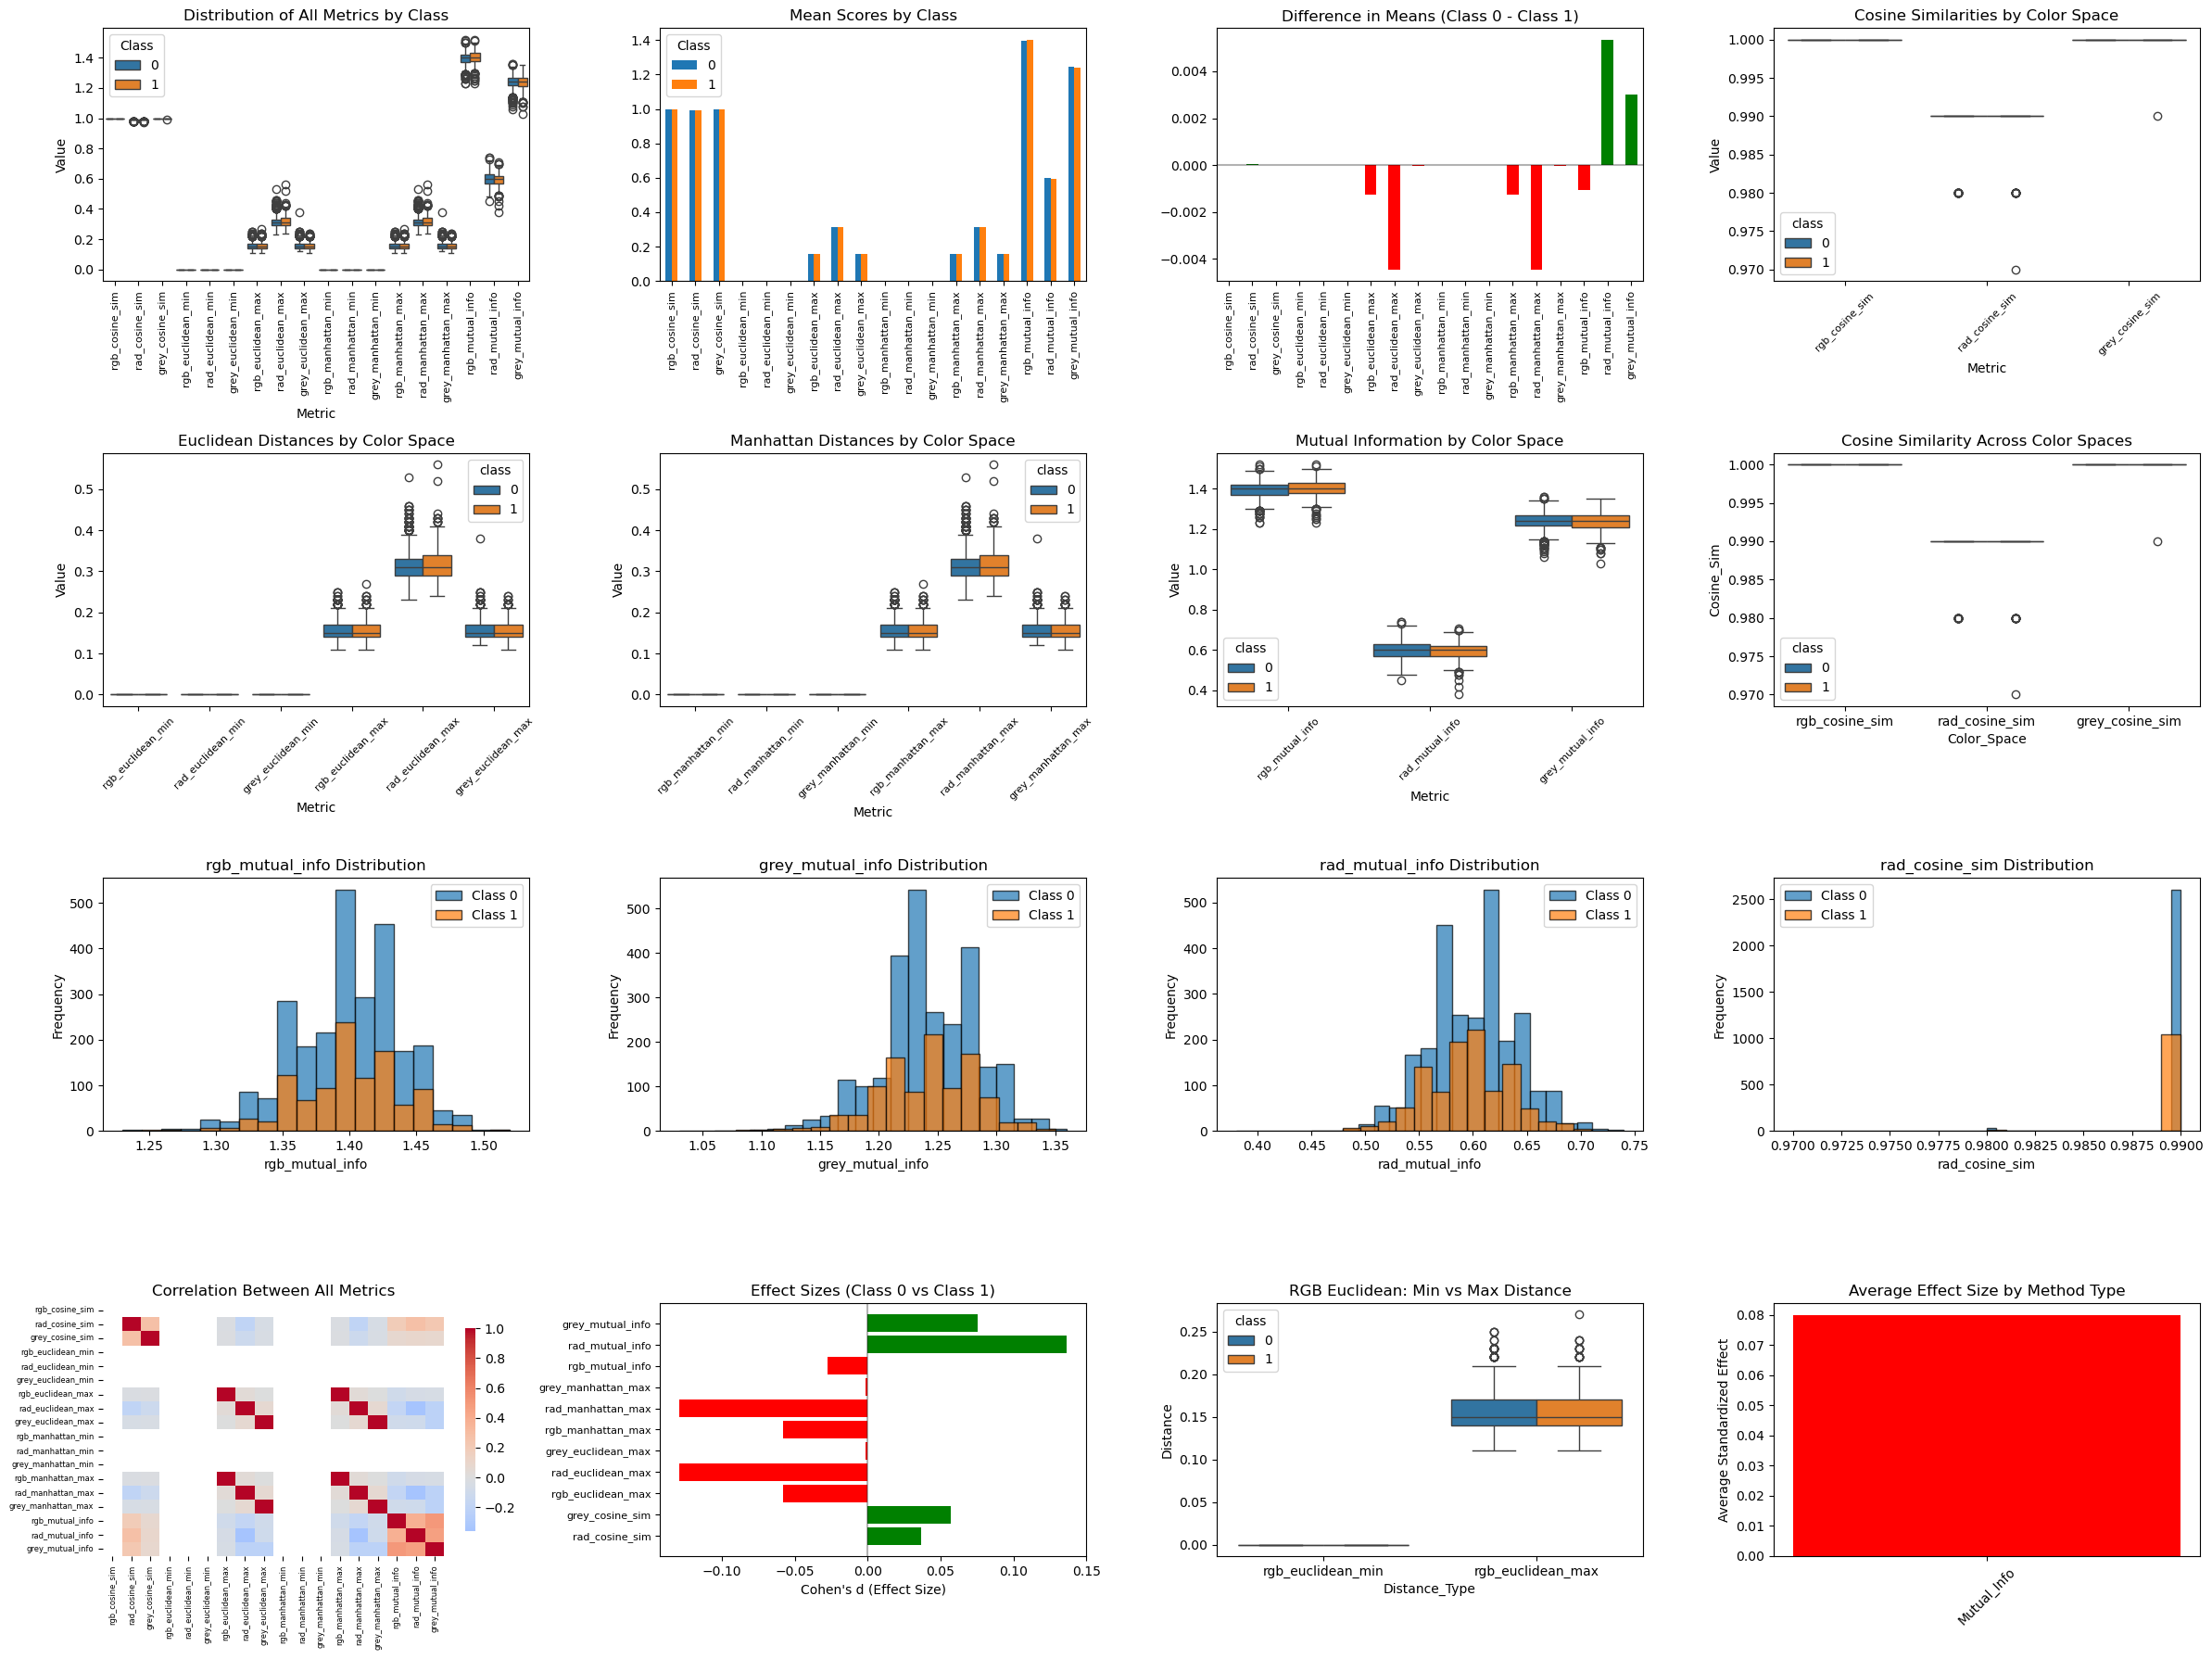

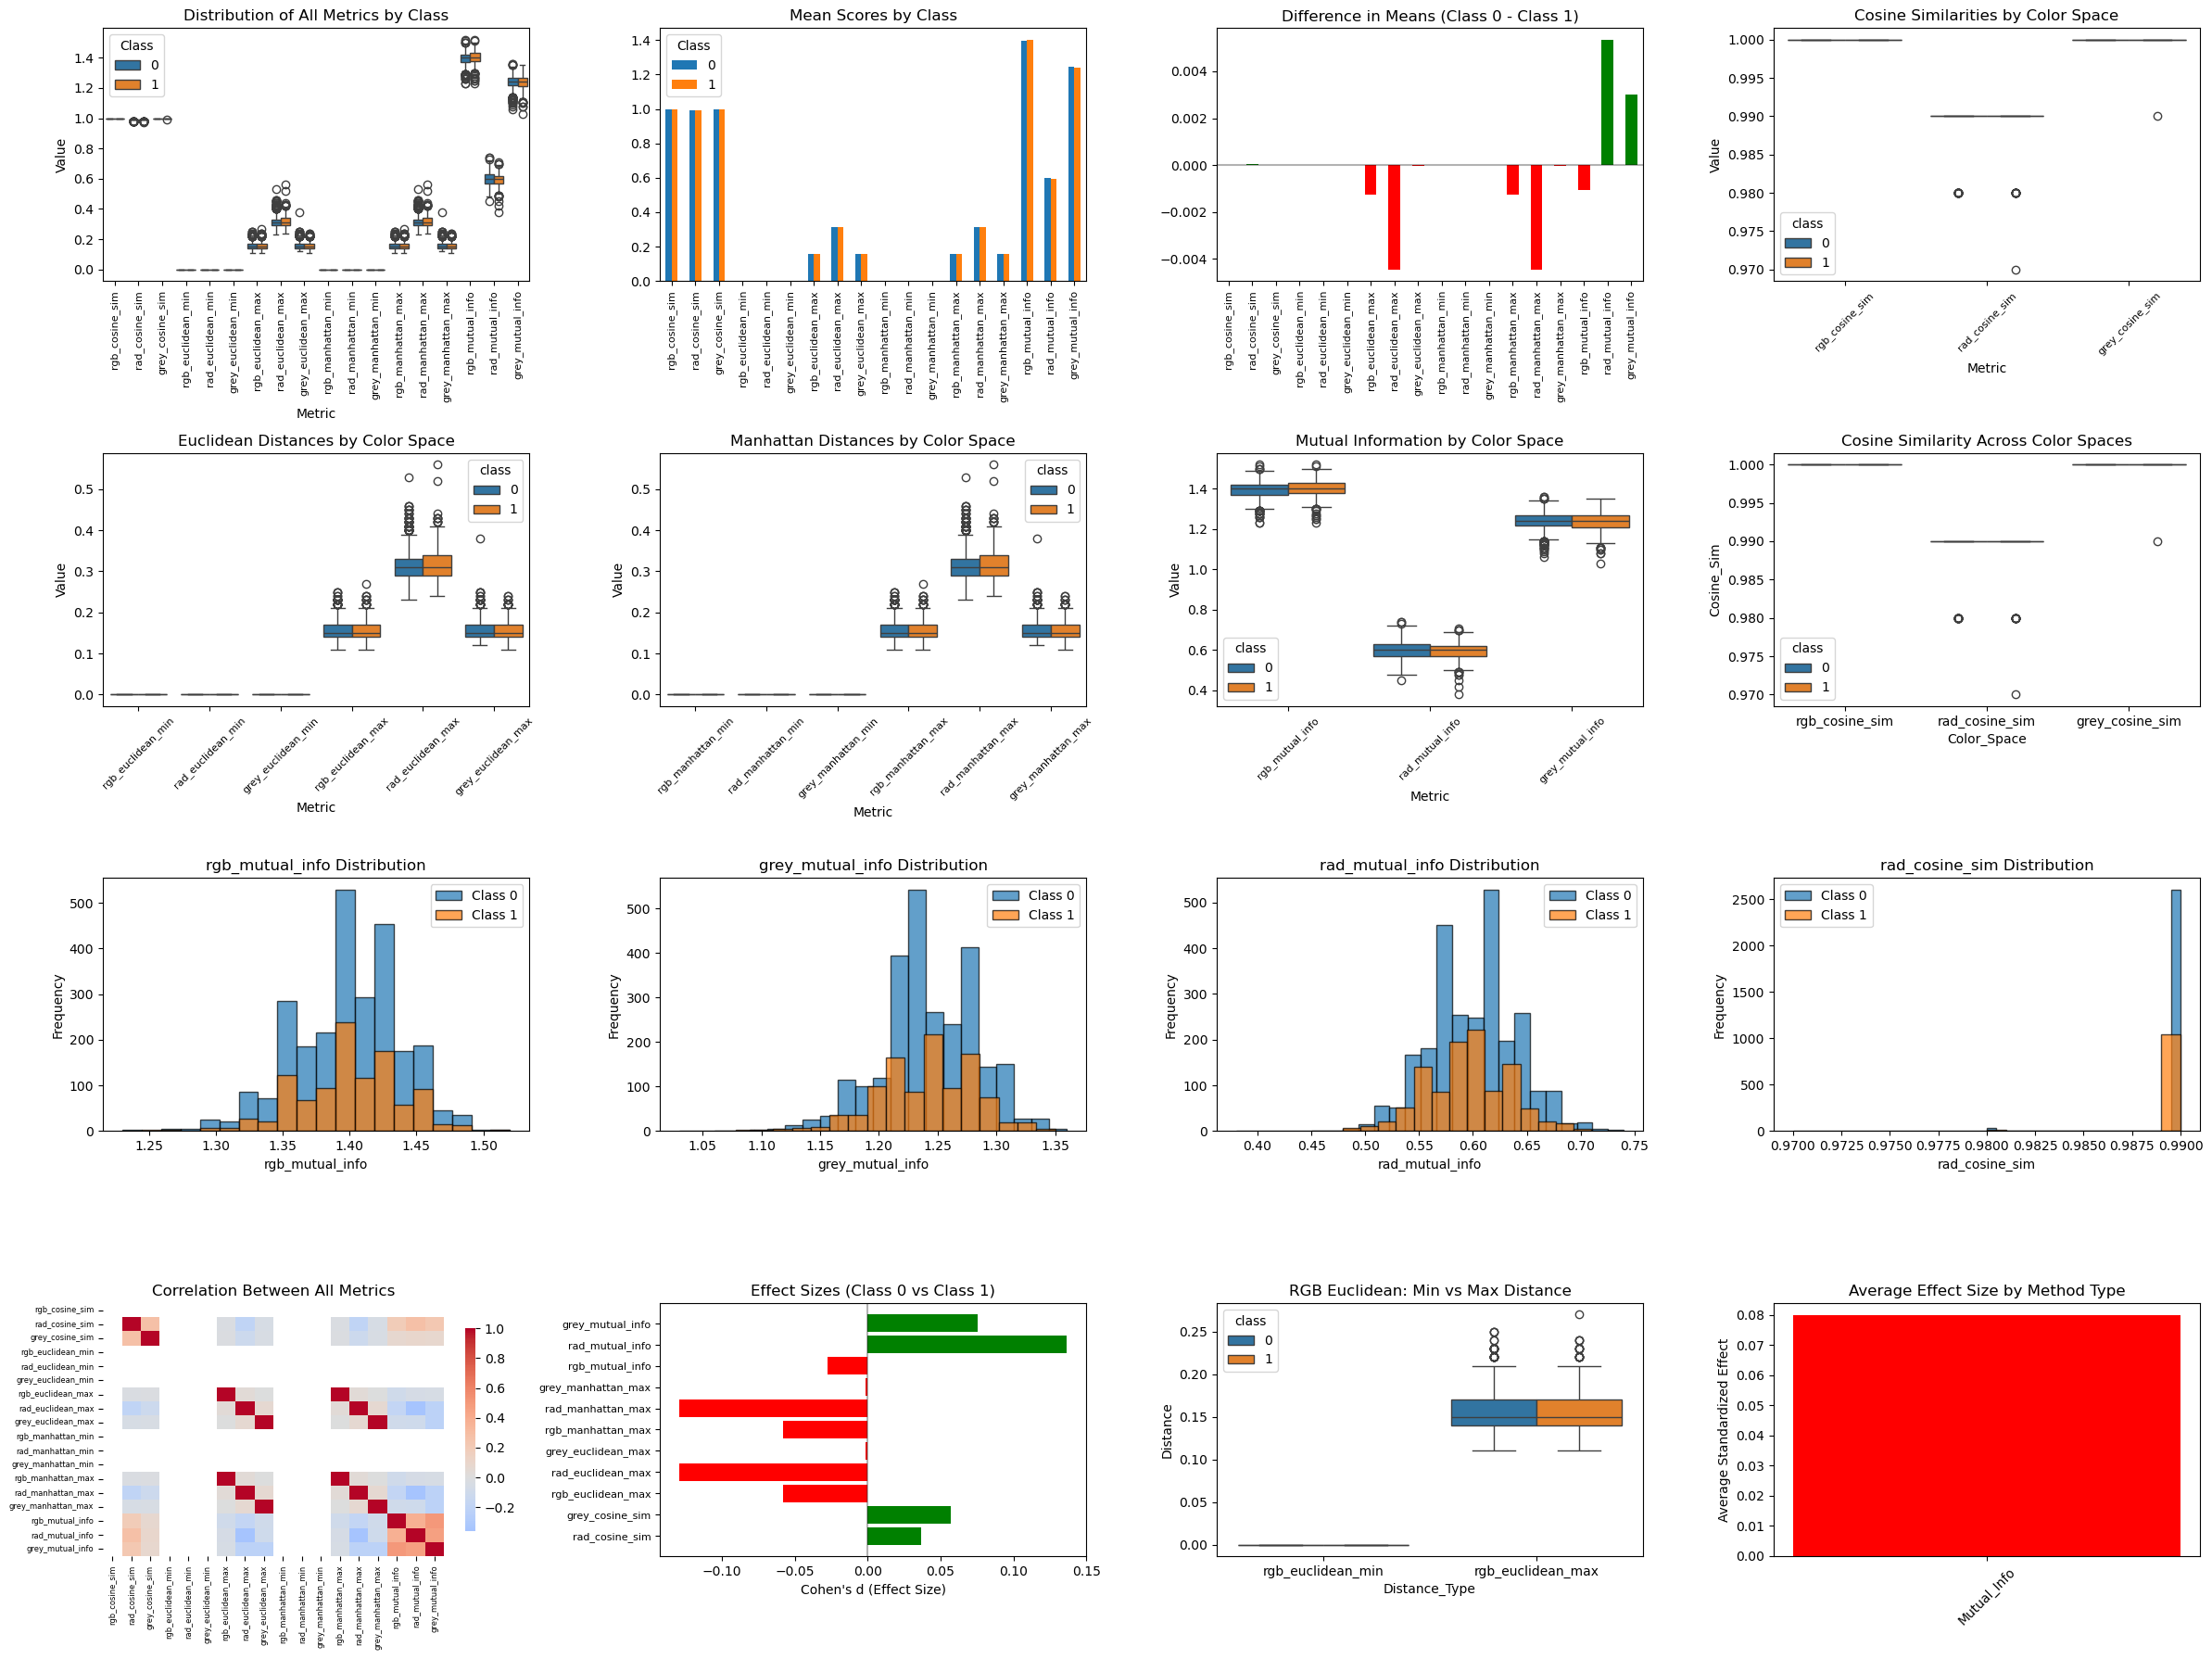

In [180]:
analyze_distance_metrics(analyze_df)

In [164]:
results_df = statistical_analysis_distances(analyze_df)


Performing statistical tests...
DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9899, Std = 0.0011, N = 2628
Class 1: Mean = 0.9898, Std = 0.0013, N = 1060
Difference: 0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1397449.5000
P-value: 0.417551
Significant: No (α = 0.05)
Cohen's d: 0.0367 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0

In [165]:
generate_distance_report(analyze_df, results_df)


Generating summary report...

DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 18
Metrics showing significant differences: 3
Percentage of metrics with significant differences: 16.7%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/3 metrics
  • Average |Effect Size|: 0.031
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = 0.037 ↑
    - Grey Model: ✗ Cohen's d = 0.057 ↑

Euclidean Distance:
  • Significant: 1/6 metrics
  • Average |Effect Size|: 0.031
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = -0.058 ↓
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✓ Cohen's d = -0.129 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.001 ↓

Manhattan Distance:
  • Significant: 1/6 metrics
  • Average |Effect Size|: 0.031
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = -0.058 ↓
    - RAD Model (Min): 

#### Adding single channel

In [151]:
analyze_df = pd.read_csv('merged_lungseg_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = analyze_df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info', 'single_cosine_sim', 'single_euclidean_max',
       'single_euclidean_min', 'single_manhattan_max', 'single_manhattan_min',
       'single_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)

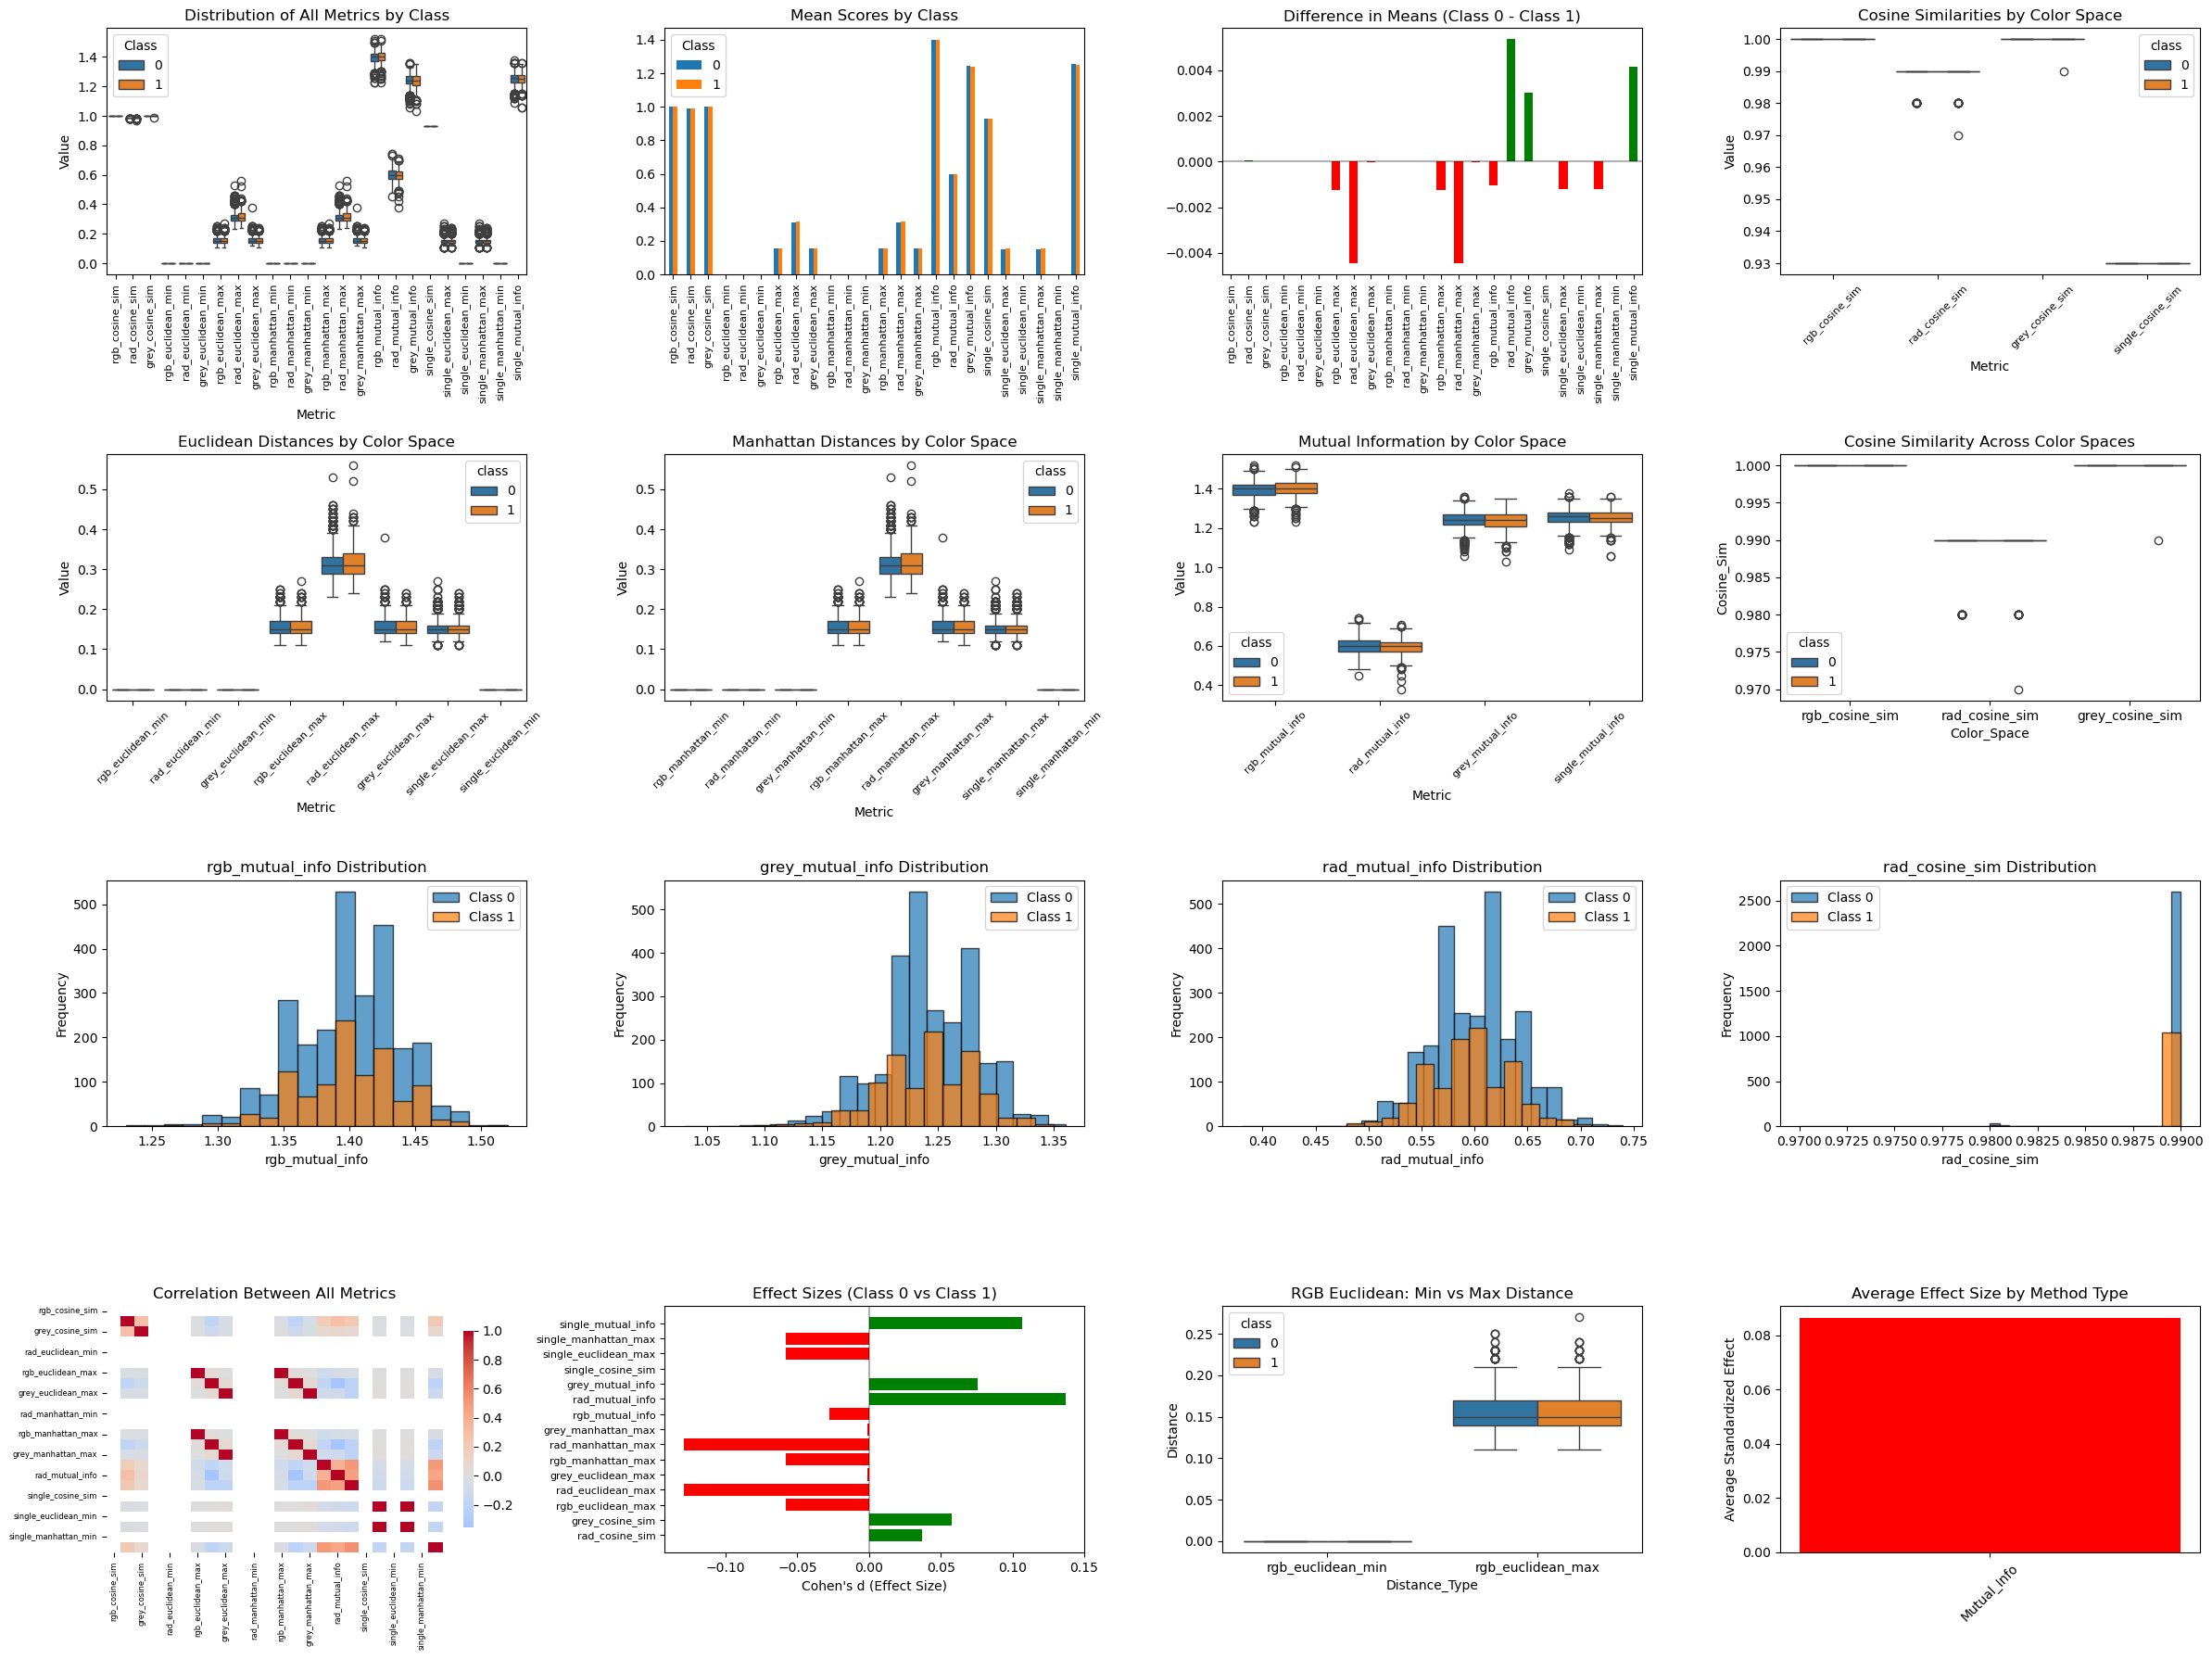

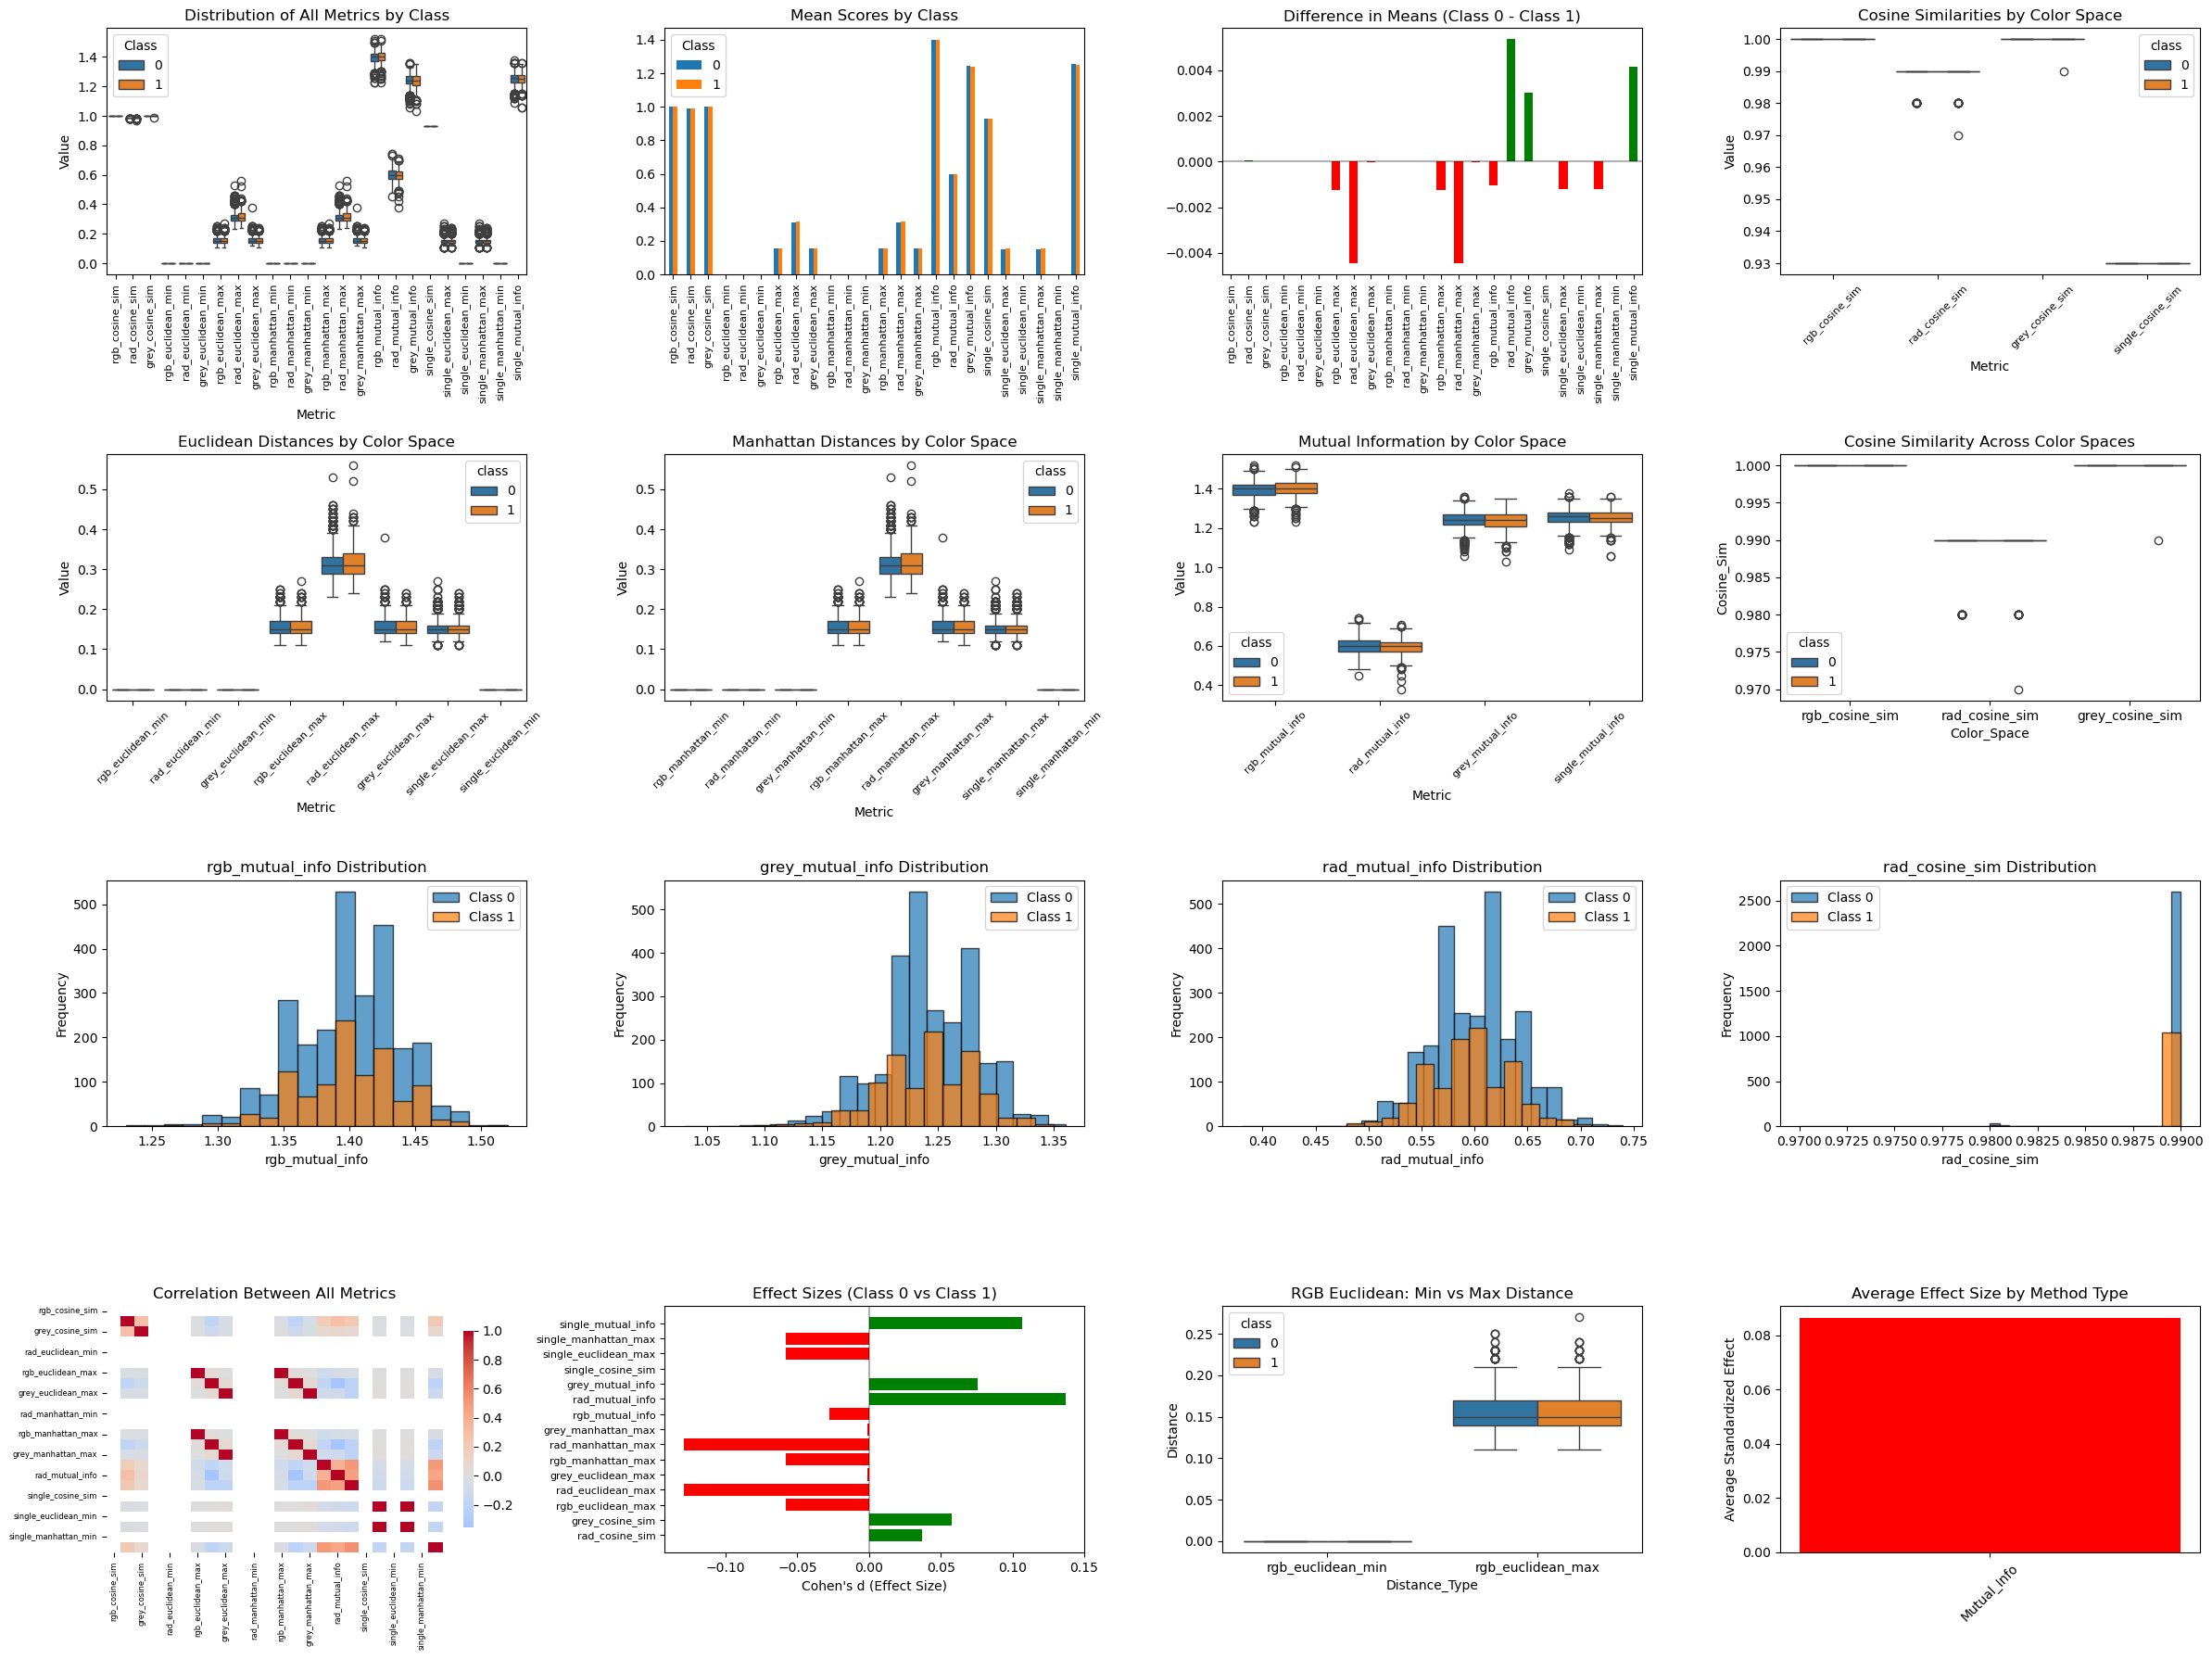

In [152]:
analyze_distance_metrics(analyze_df)

In [153]:
results_df = statistical_analysis_distances(analyze_df,True)

DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9899, Std = 0.0011, N = 2628
Class 1: Mean = 0.9898, Std = 0.0013, N = 1060
Difference: 0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1397449.5000
P-value: 0.417551
Significant: No (α = 0.05)
Cohen's d: 0.0367 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1

In [154]:
generate_distance_report(analyze_df, results_df)


DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 24
Metrics showing significant differences: 4
Percentage of metrics with significant differences: 16.7%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/4 metrics
  • Average |Effect Size|: 0.023
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = 0.037 ↑
    - Grey Model: ✗ Cohen's d = 0.057 ↑
    - Single Model: ✗ Cohen's d = 0.000 ↓

Euclidean Distance:
  • Significant: 1/8 metrics
  • Average |Effect Size|: 0.031
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = -0.058 ↓
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✓ Cohen's d = -0.129 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.001 ↓
    - Single Model (Min): ✗ Cohen's d = 0.000 ↓
    - Single Model (Max): ✗ Cohen's d = -0.058 ↓

Manhattan Distance:
  • Significant: 1/8 metrics
  • Average |Effect Size|: 0.031
    -

### Arch Seg

In [181]:
df = pd.read_csv('arch_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)

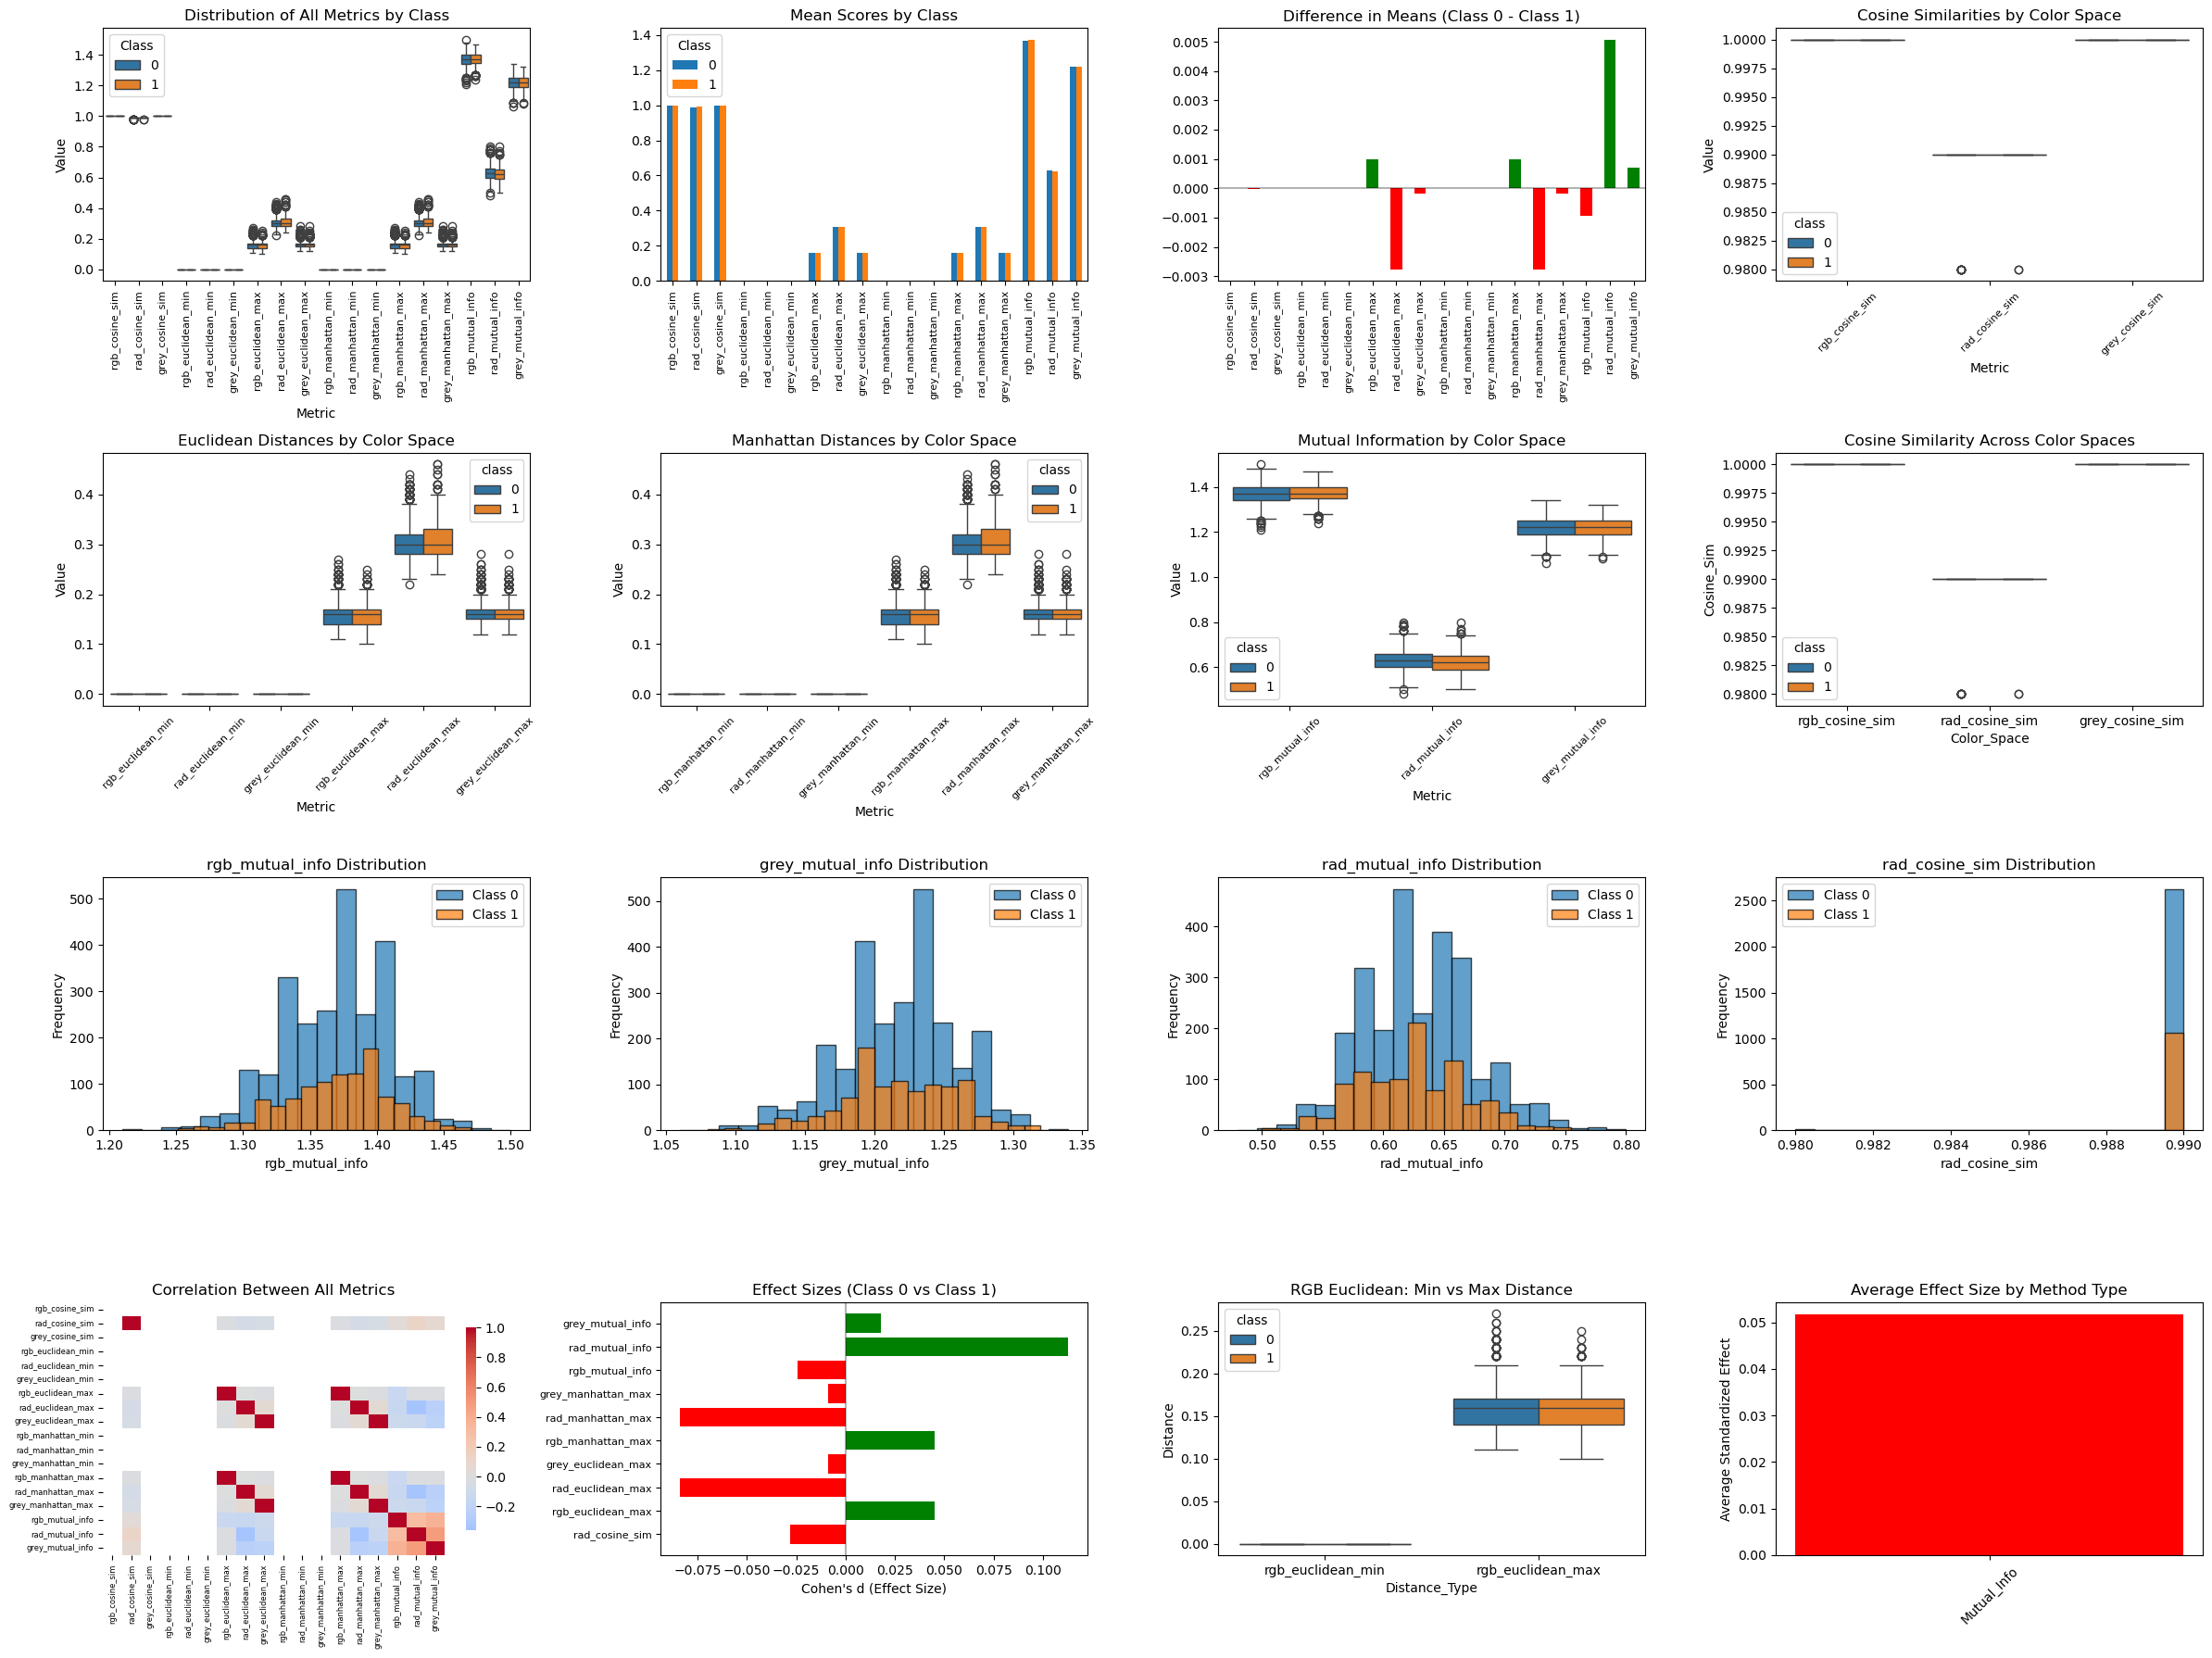

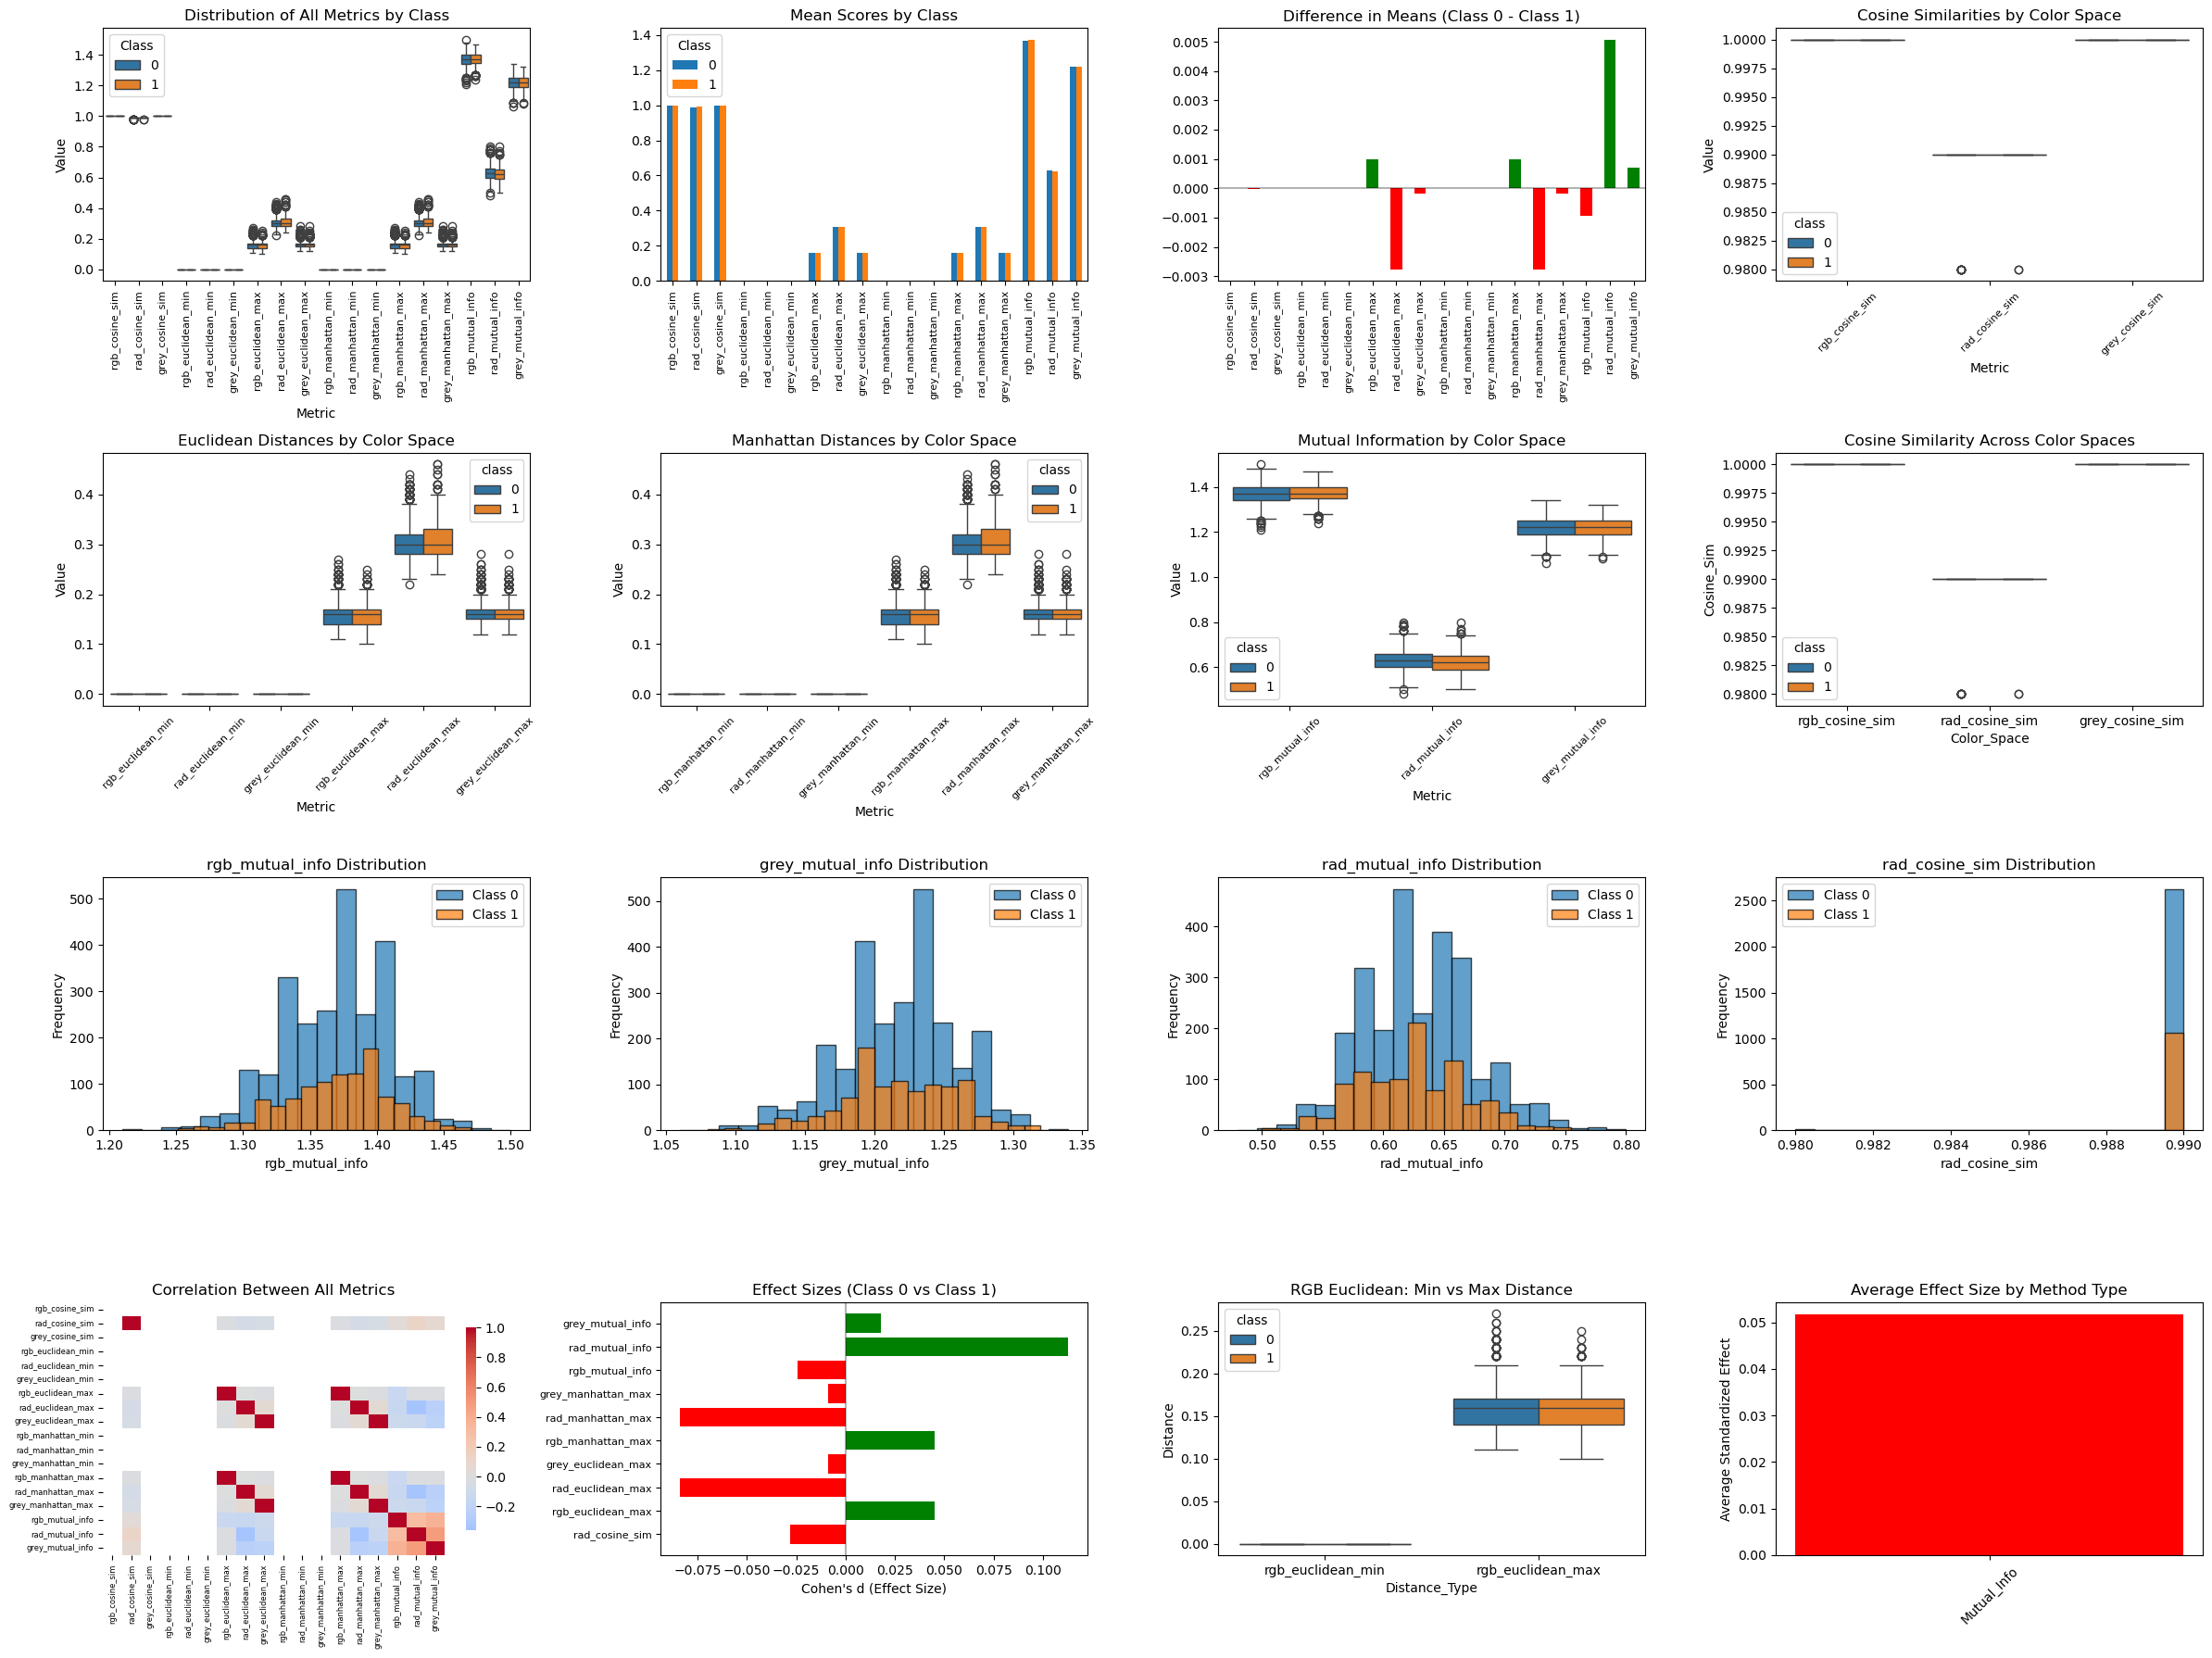

In [182]:
analyze_distance_metrics(analyze_df)

In [169]:
results_df = statistical_analysis_distances(analyze_df)


Performing statistical tests...
DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9900, Std = 0.0006, N = 2628
Class 1: Mean = 0.9900, Std = 0.0004, N = 1060
Difference: -0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1390698.0000
P-value: 0.438472
Significant: No (α = 0.05)
Cohen's d: -0.0282 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std =

In [170]:
generate_distance_report(analyze_df, results_df)


Generating summary report...

DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 18
Metrics showing significant differences: 3
Percentage of metrics with significant differences: 16.7%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/3 metrics
  • Average |Effect Size|: 0.009
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = -0.028 ↓
    - Grey Model: ✗ Cohen's d = 0.000 ↓

Euclidean Distance:
  • Significant: 1/6 metrics
  • Average |Effect Size|: 0.023
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.045 ↑
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✓ Cohen's d = -0.084 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.009 ↓

Manhattan Distance:
  • Significant: 1/6 metrics
  • Average |Effect Size|: 0.023
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.045 ↑
    - RAD Model (Min): ✗

#### Adding single channel

In [111]:
analyze_df = pd.read_csv('merged_arch_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = analyze_df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info', 'single_cosine_sim', 'single_euclidean_max',
       'single_euclidean_min', 'single_manhattan_max', 'single_manhattan_min',
       'single_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)

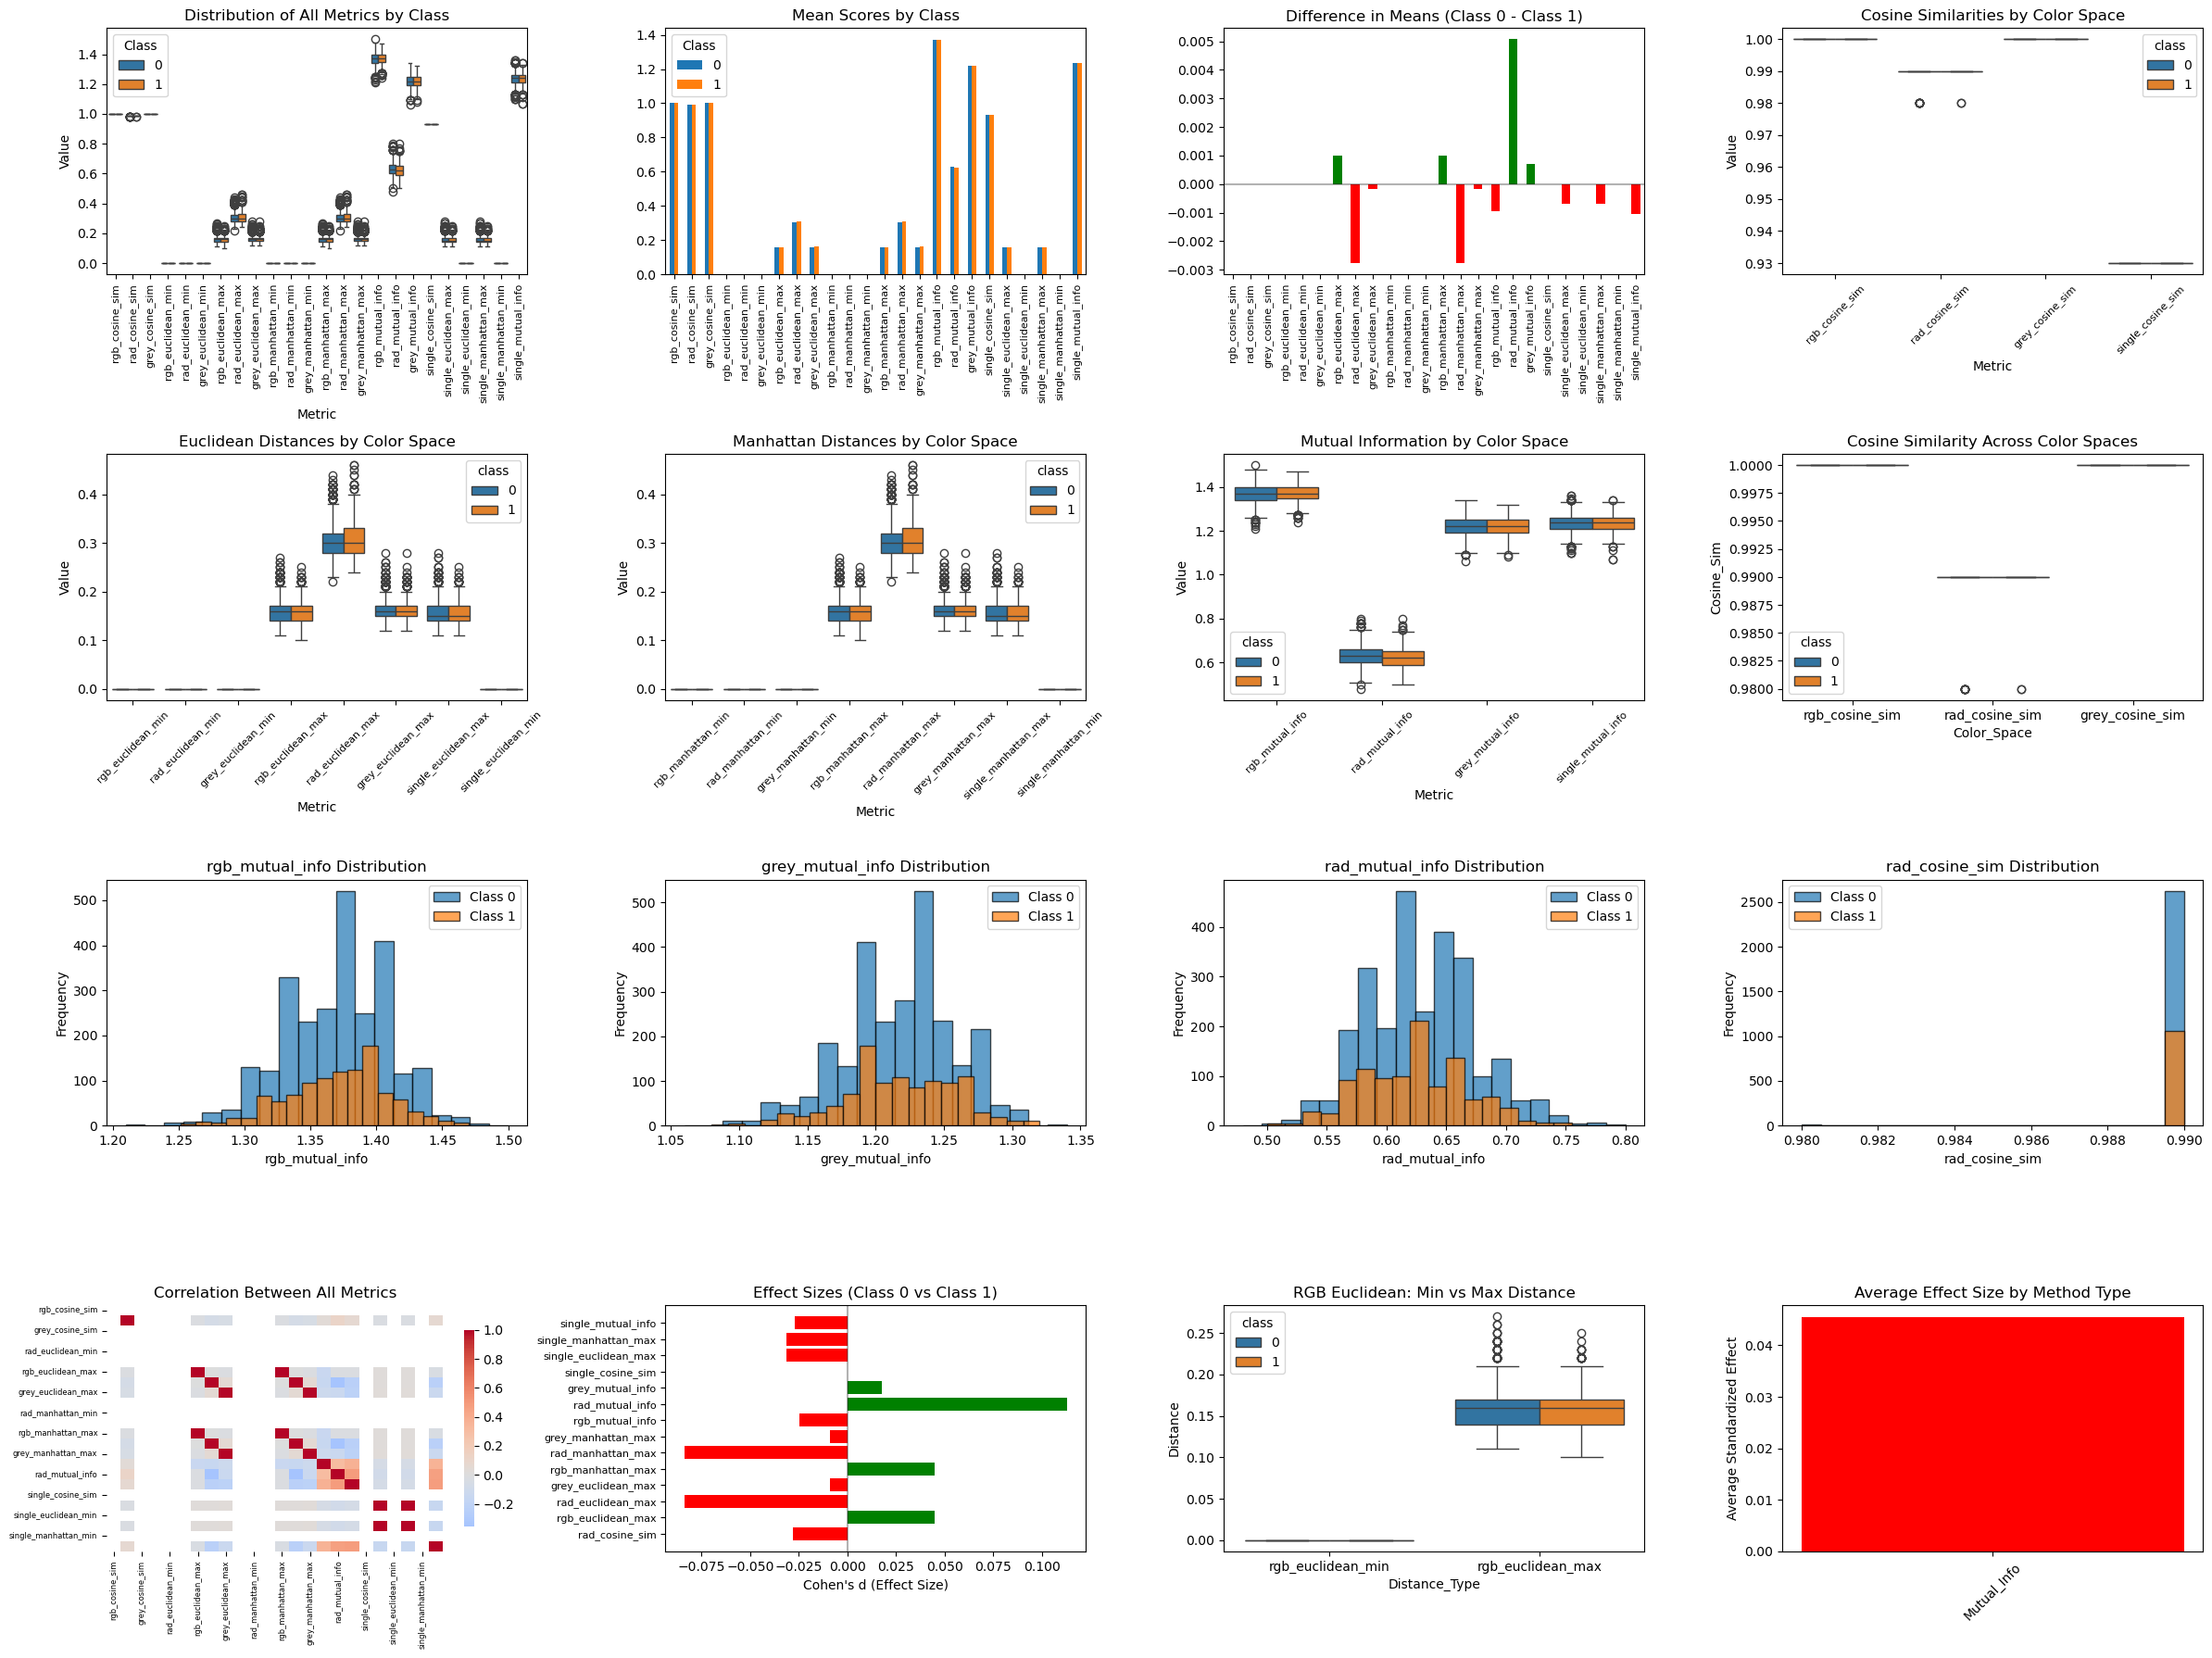

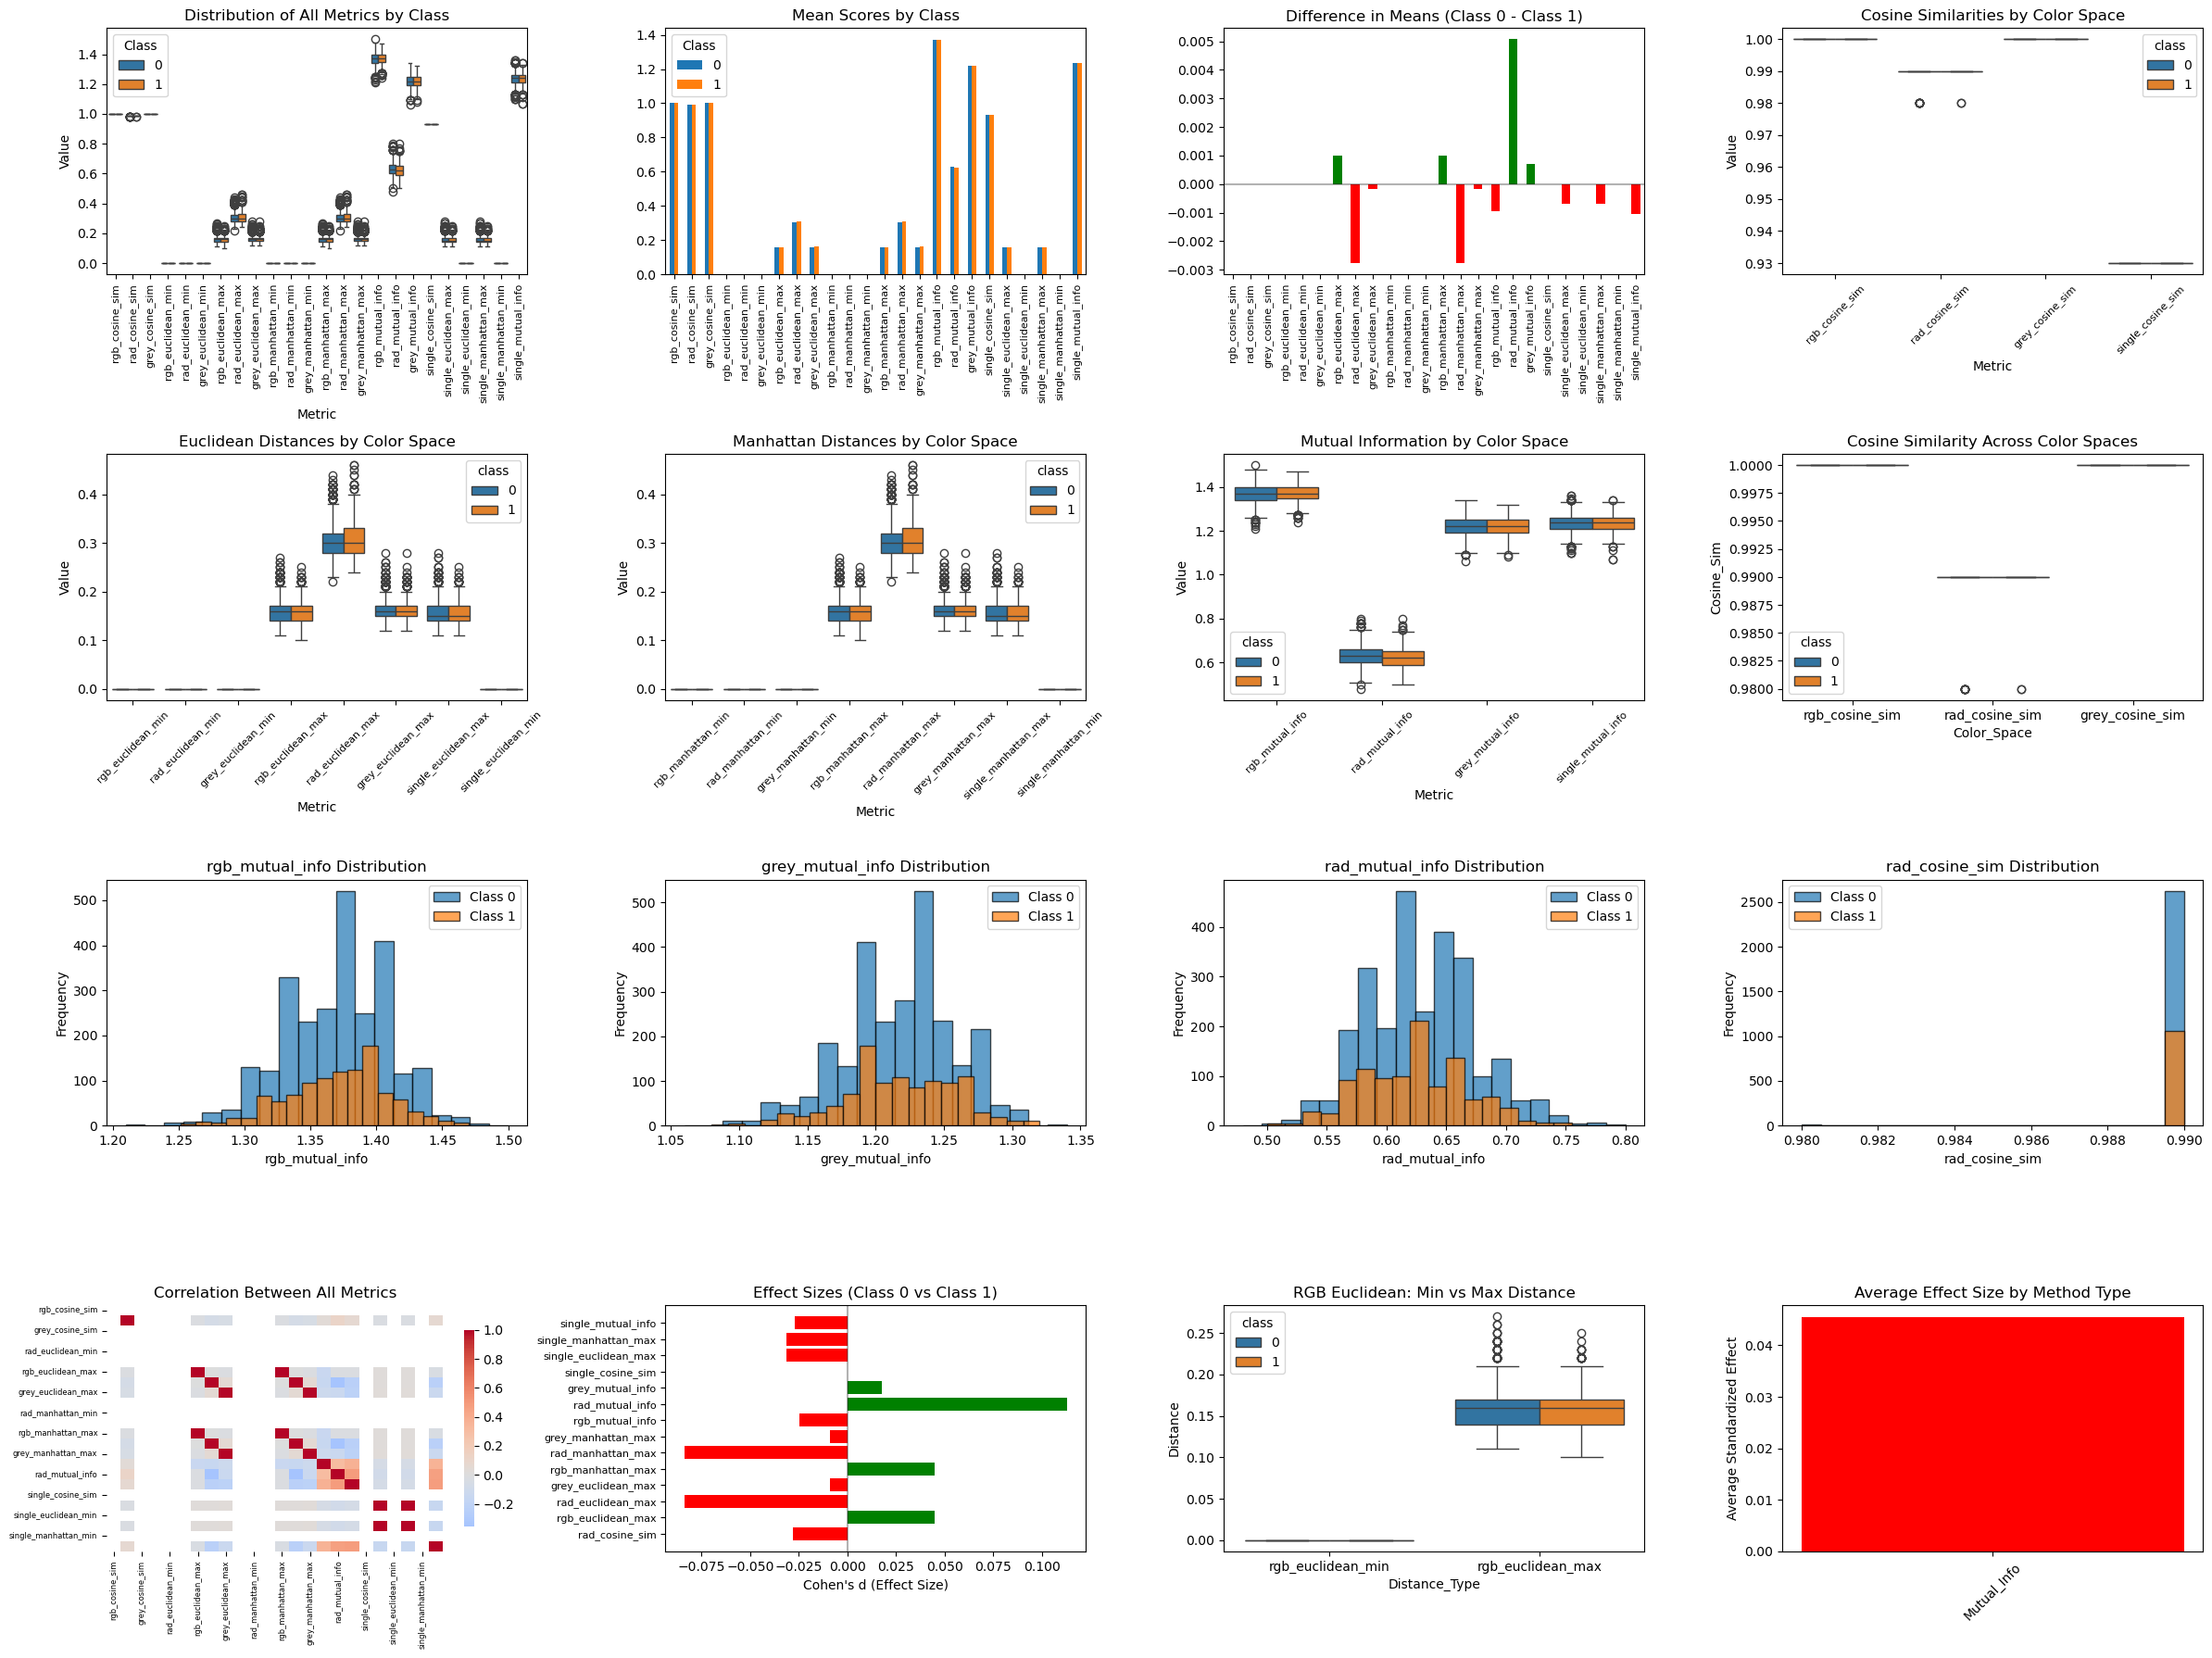

In [118]:
analyze_distance_metrics(analyze_df)

In [125]:
results_df = statistical_analysis_distances(analyze_df,True)

DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9900, Std = 0.0006, N = 2628
Class 1: Mean = 0.9900, Std = 0.0004, N = 1060
Difference: -0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1390698.0000
P-value: 0.438472
Significant: No (α = 0.05)
Cohen's d: -0.0282 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean =

In [126]:
generate_distance_report(analyze_df, results_df)


DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 24
Metrics showing significant differences: 3
Percentage of metrics with significant differences: 12.5%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/4 metrics
  • Average |Effect Size|: 0.007
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = -0.028 ↓
    - Grey Model: ✗ Cohen's d = 0.000 ↓
    - Single Model: ✗ Cohen's d = 0.000 ↓

Euclidean Distance:
  • Significant: 1/8 metrics
  • Average |Effect Size|: 0.021
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.045 ↑
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✓ Cohen's d = -0.084 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.009 ↓
    - Single Model (Min): ✗ Cohen's d = 0.000 ↓
    - Single Model (Max): ✗ Cohen's d = -0.031 ↓

Manhattan Distance:
  • Significant: 1/8 metrics
  • Average |Effect Size|: 0.021
    -

### Crop Seg

In [184]:
df = pd.read_csv('crop_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)

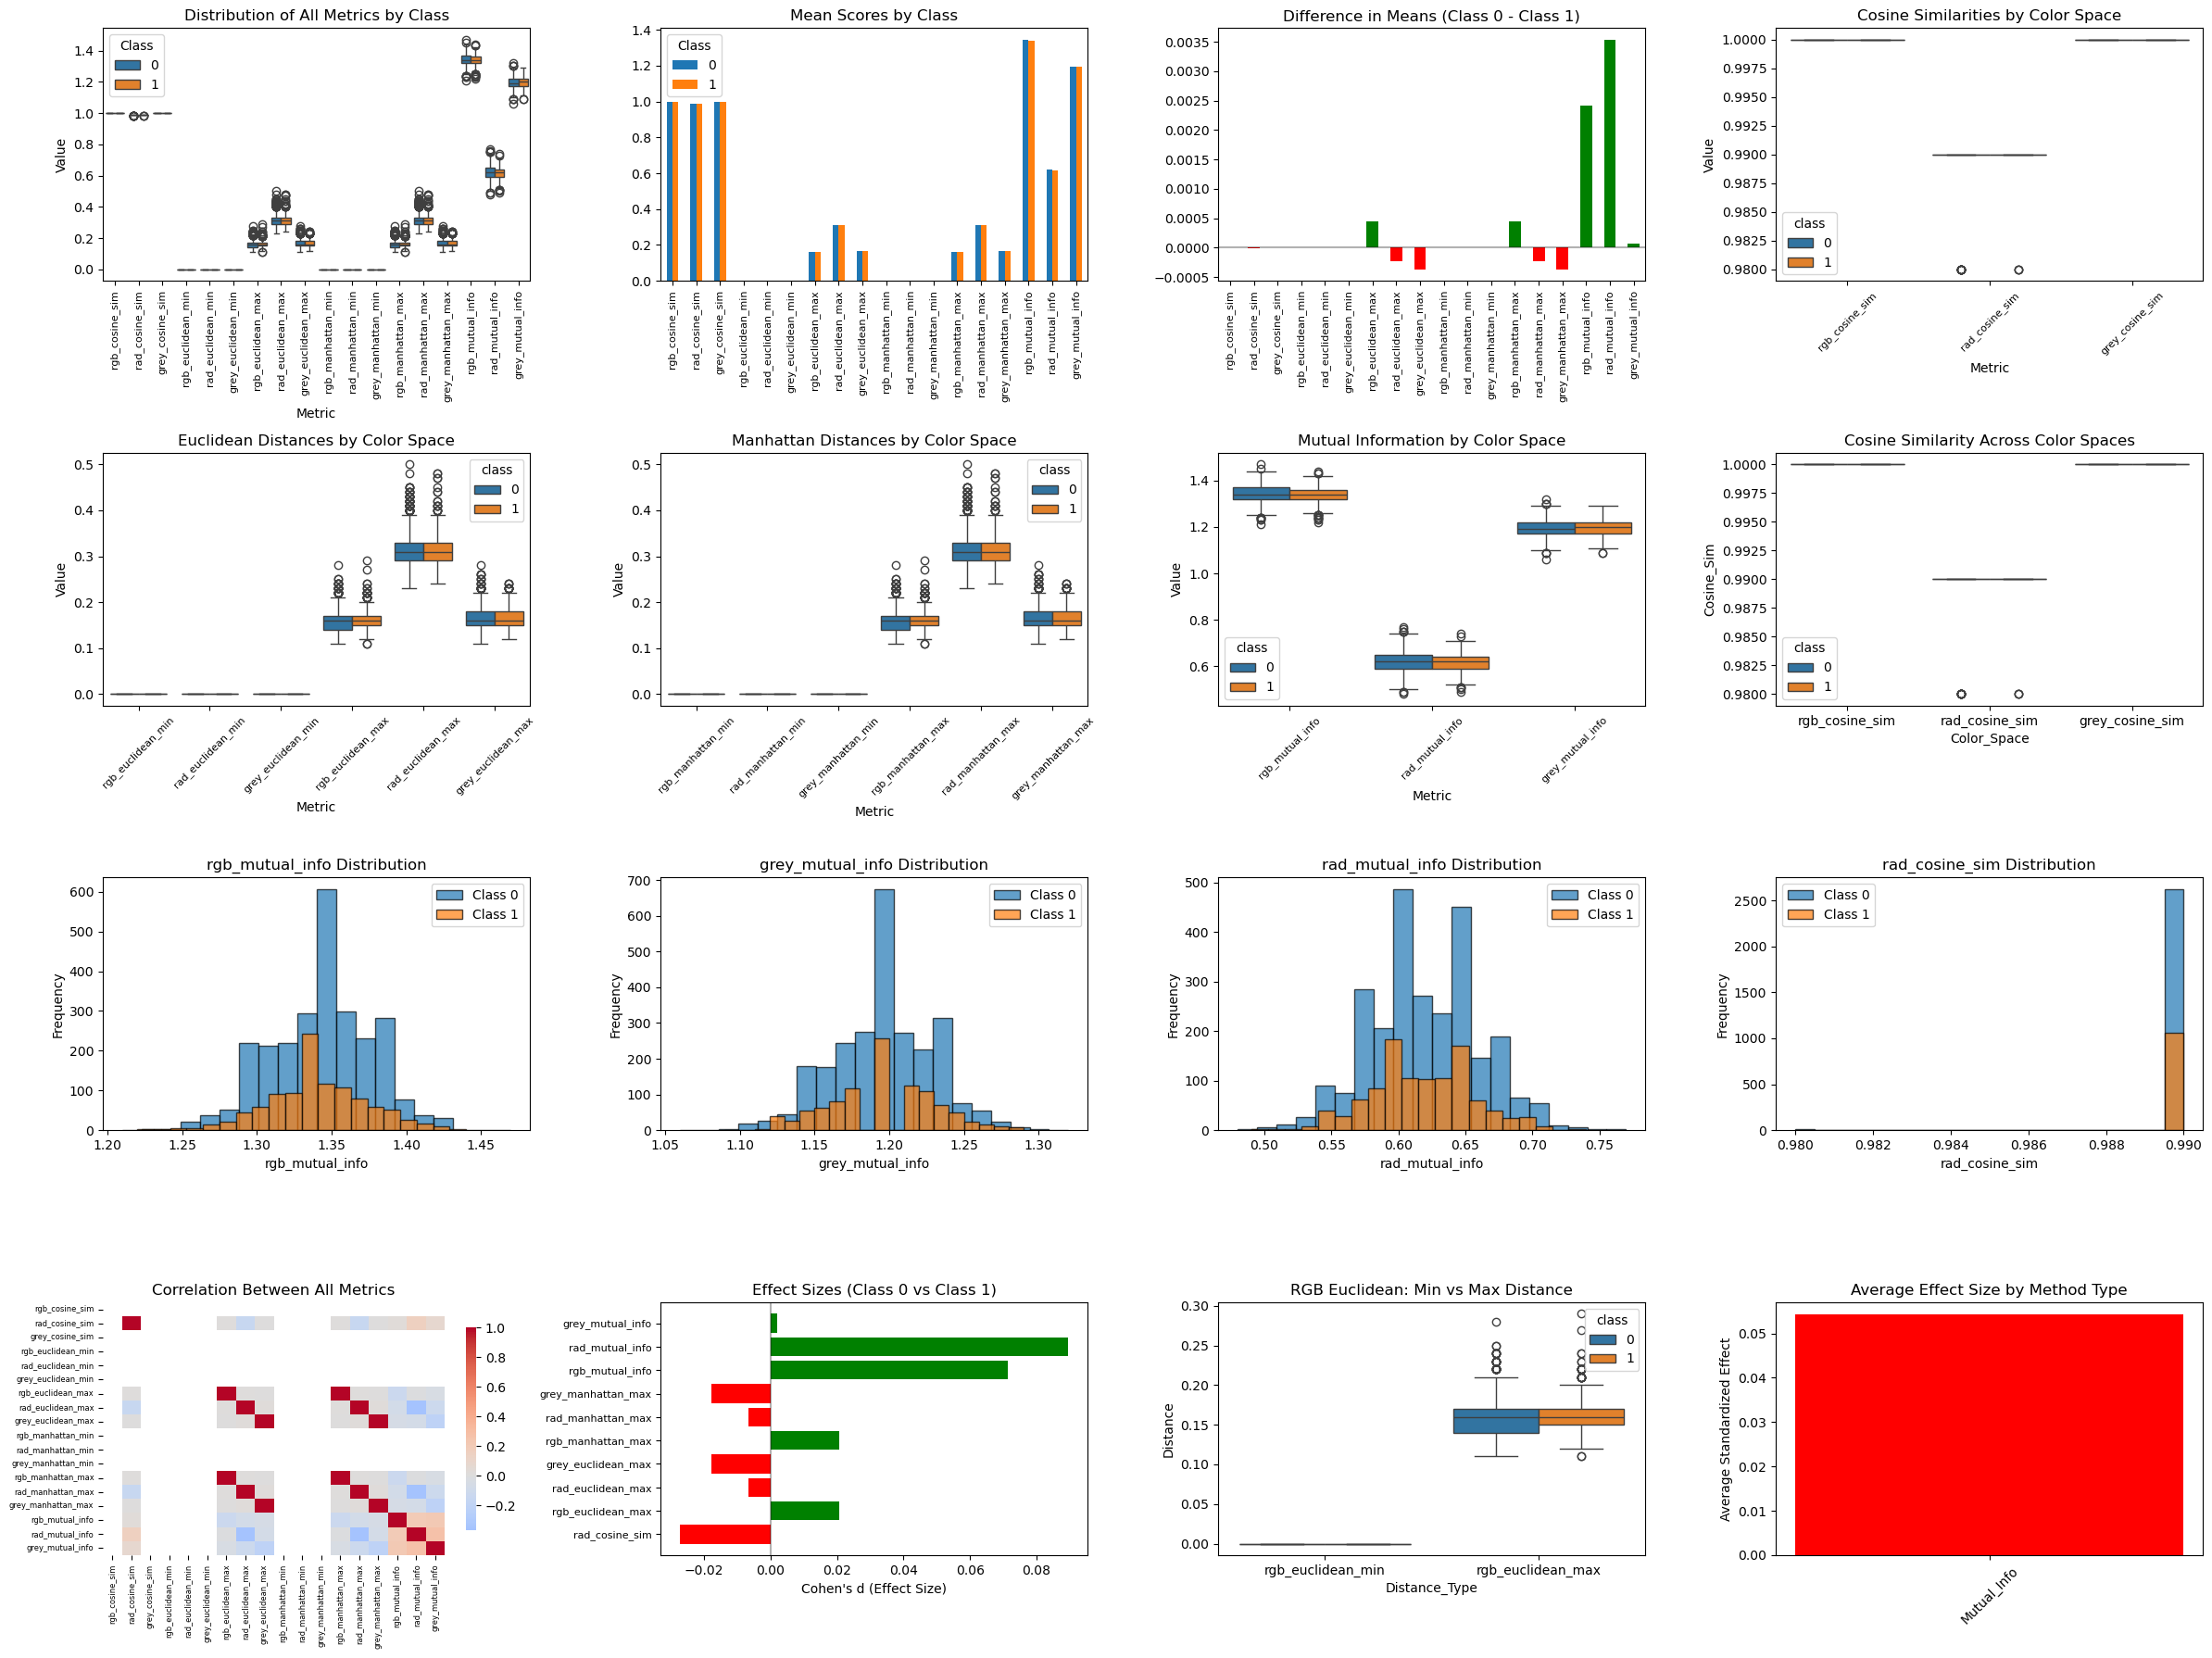

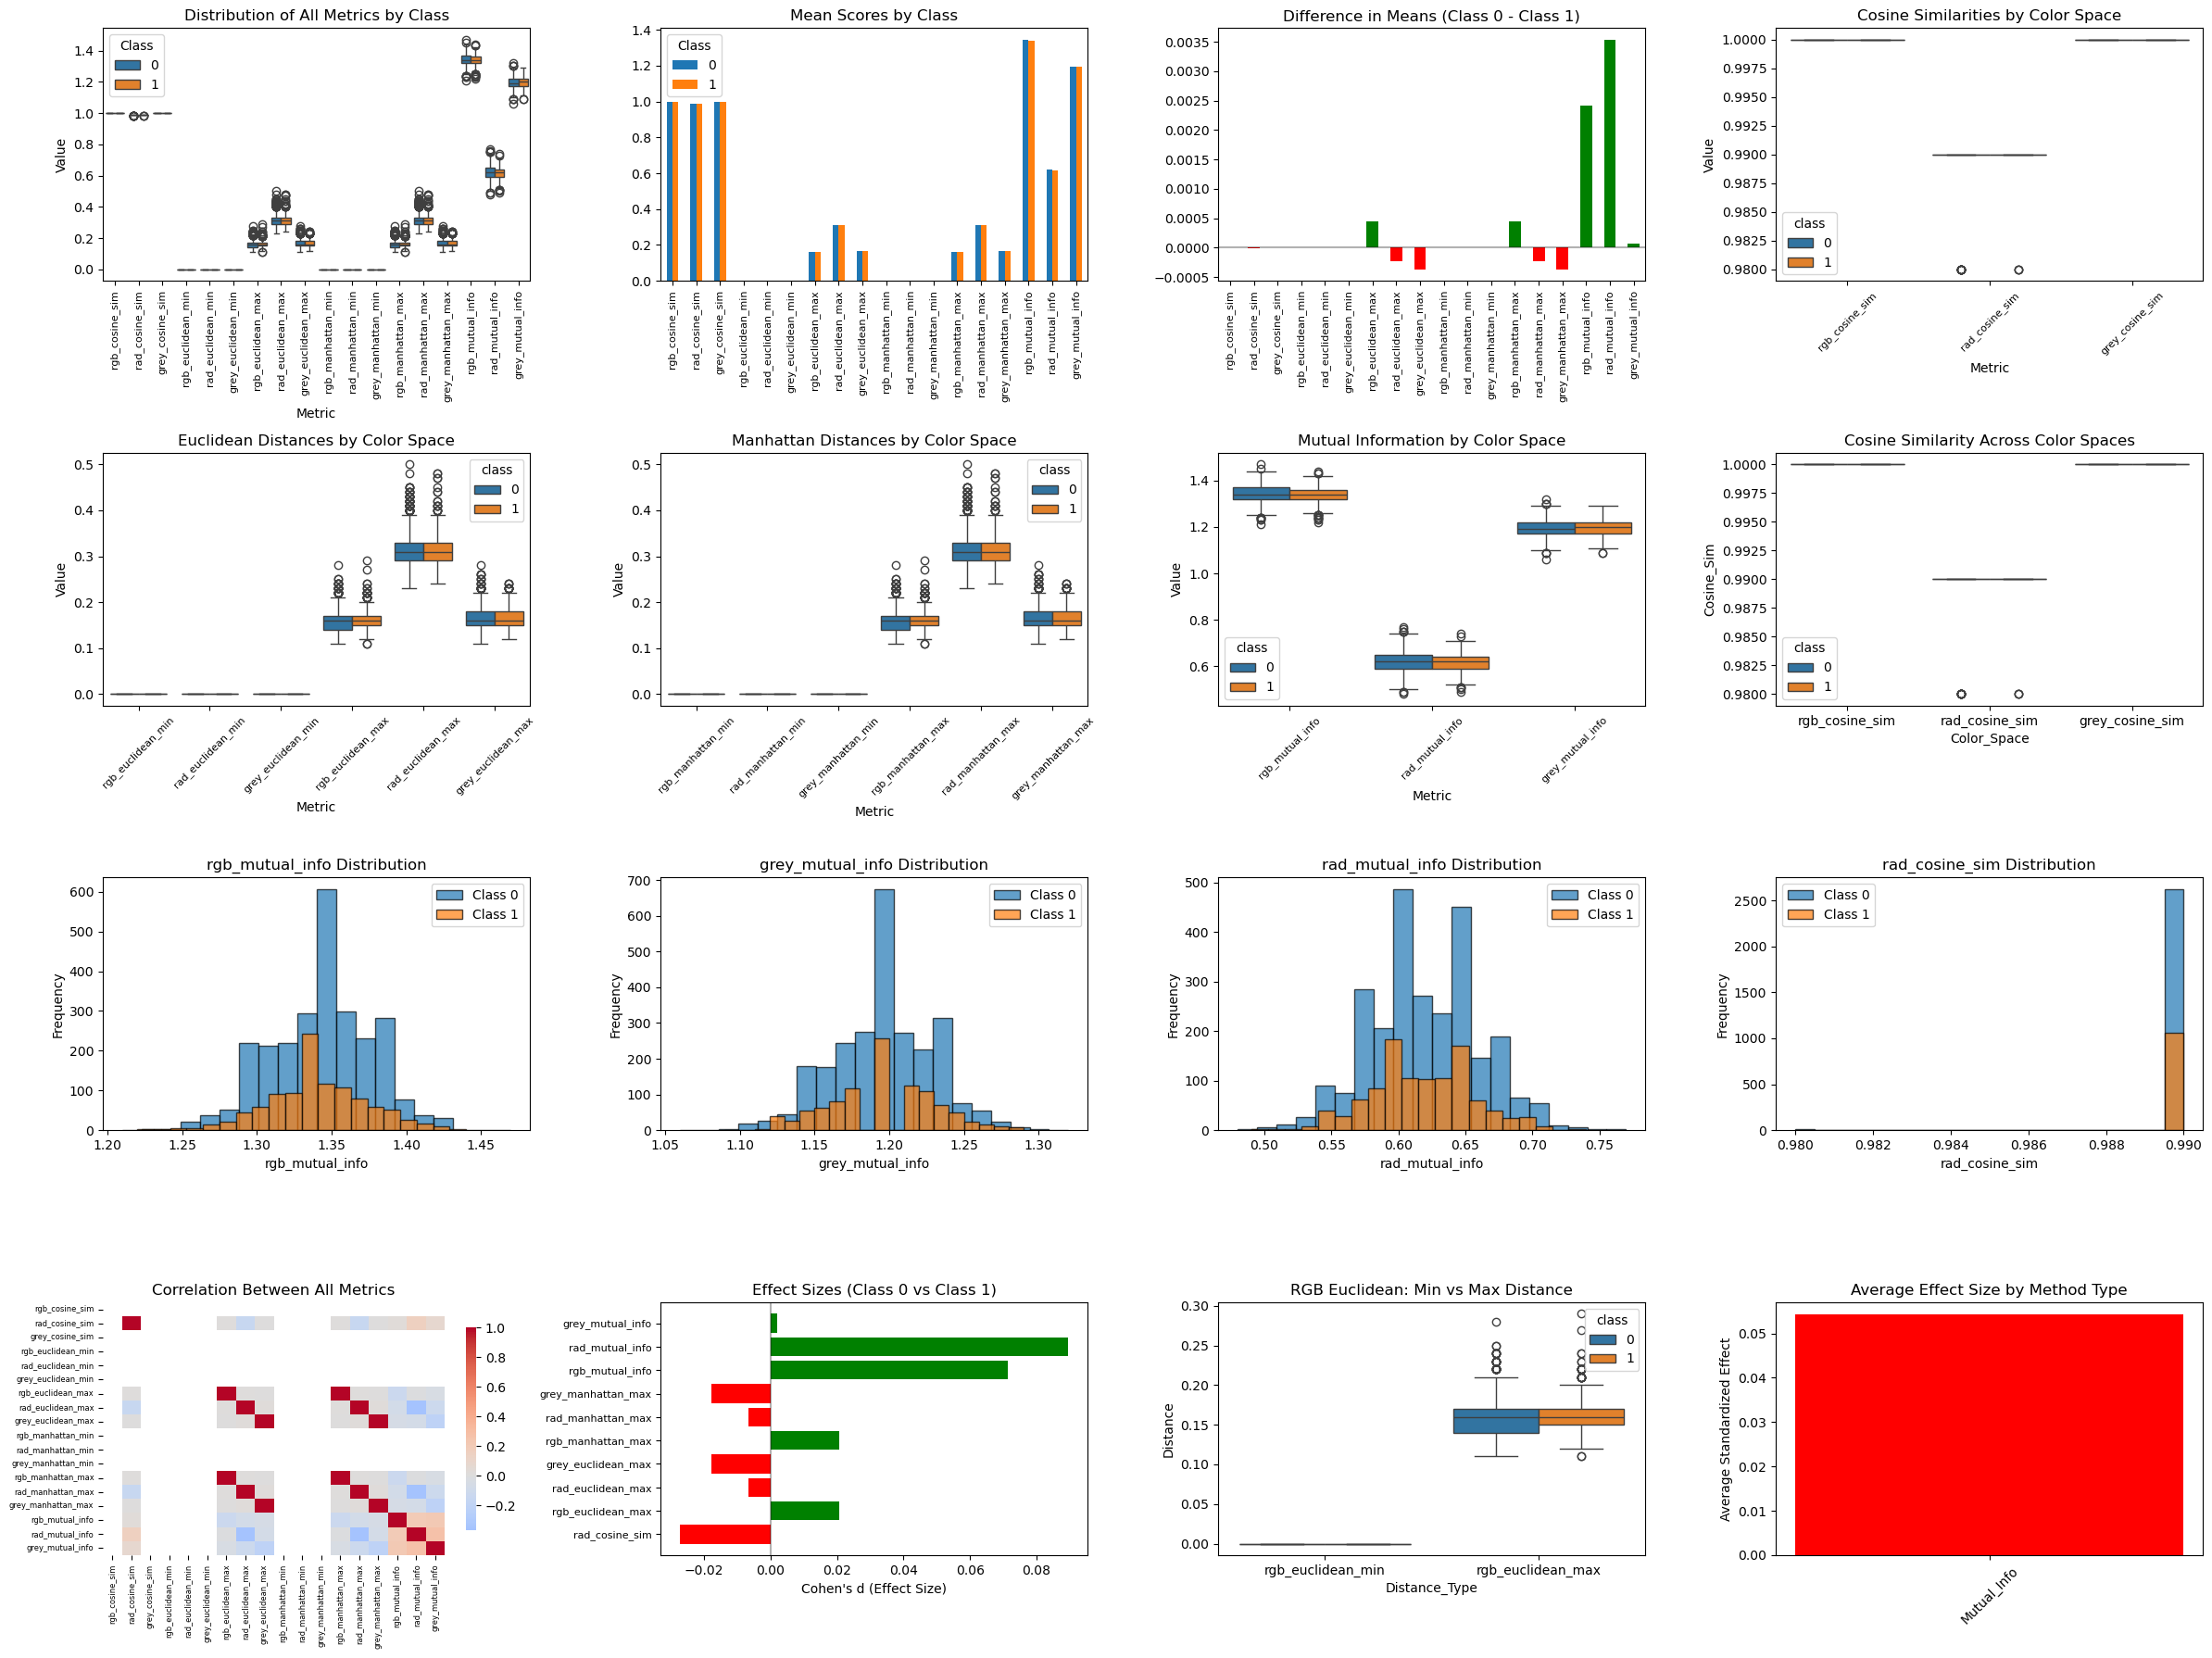

In [185]:
analyze_distance_metrics(analyze_df)

In [173]:
results_df = statistical_analysis_distances(analyze_df)

DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9900, Std = 0.0007, N = 2628
Class 1: Mean = 0.9900, Std = 0.0005, N = 1060
Difference: -0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1390422.0000
P-value: 0.453619
Significant: No (α = 0.05)
Cohen's d: -0.0273 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean =

In [174]:
generate_distance_report(analyze_df, results_df)


DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 18
Metrics showing significant differences: 2
Percentage of metrics with significant differences: 11.1%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/3 metrics
  • Average |Effect Size|: 0.009
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = -0.027 ↓
    - Grey Model: ✗ Cohen's d = 0.000 ↓

Euclidean Distance:
  • Significant: 0/6 metrics
  • Average |Effect Size|: 0.008
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.021 ↑
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✗ Cohen's d = -0.007 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.018 ↓

Manhattan Distance:
  • Significant: 0/6 metrics
  • Average |Effect Size|: 0.008
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.021 ↑
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD

#### Adding single channel

In [155]:
analyze_df = pd.read_csv('merged_crop_raw_network_similarity_metrics.csv')  # Load your actual data
analyze_df = analyze_df[['class', 'rgb_cosine_sim', 'rad_cosine_sim',
       'grey_cosine_sim', 'rgb_euclidean_min', 'rad_euclidean_min',
       'grey_euclidean_min', 'rgb_euclidean_max', 'rad_euclidean_max',
       'grey_euclidean_max', 'rgb_manhattan_min', 'rad_manhattan_min',
       'grey_manhattan_min', 'rgb_manhattan_max', 'rad_manhattan_max',
       'grey_manhattan_max', 'rgb_mutual_info', 'rad_mutual_info',
       'grey_mutual_info', 'single_cosine_sim', 'single_euclidean_max',
       'single_euclidean_min', 'single_manhattan_max', 'single_manhattan_min',
       'single_mutual_info']]
analyze_df['class'] = analyze_df['class'].apply(lambda x: 1 if x=="Nodule" else 0)

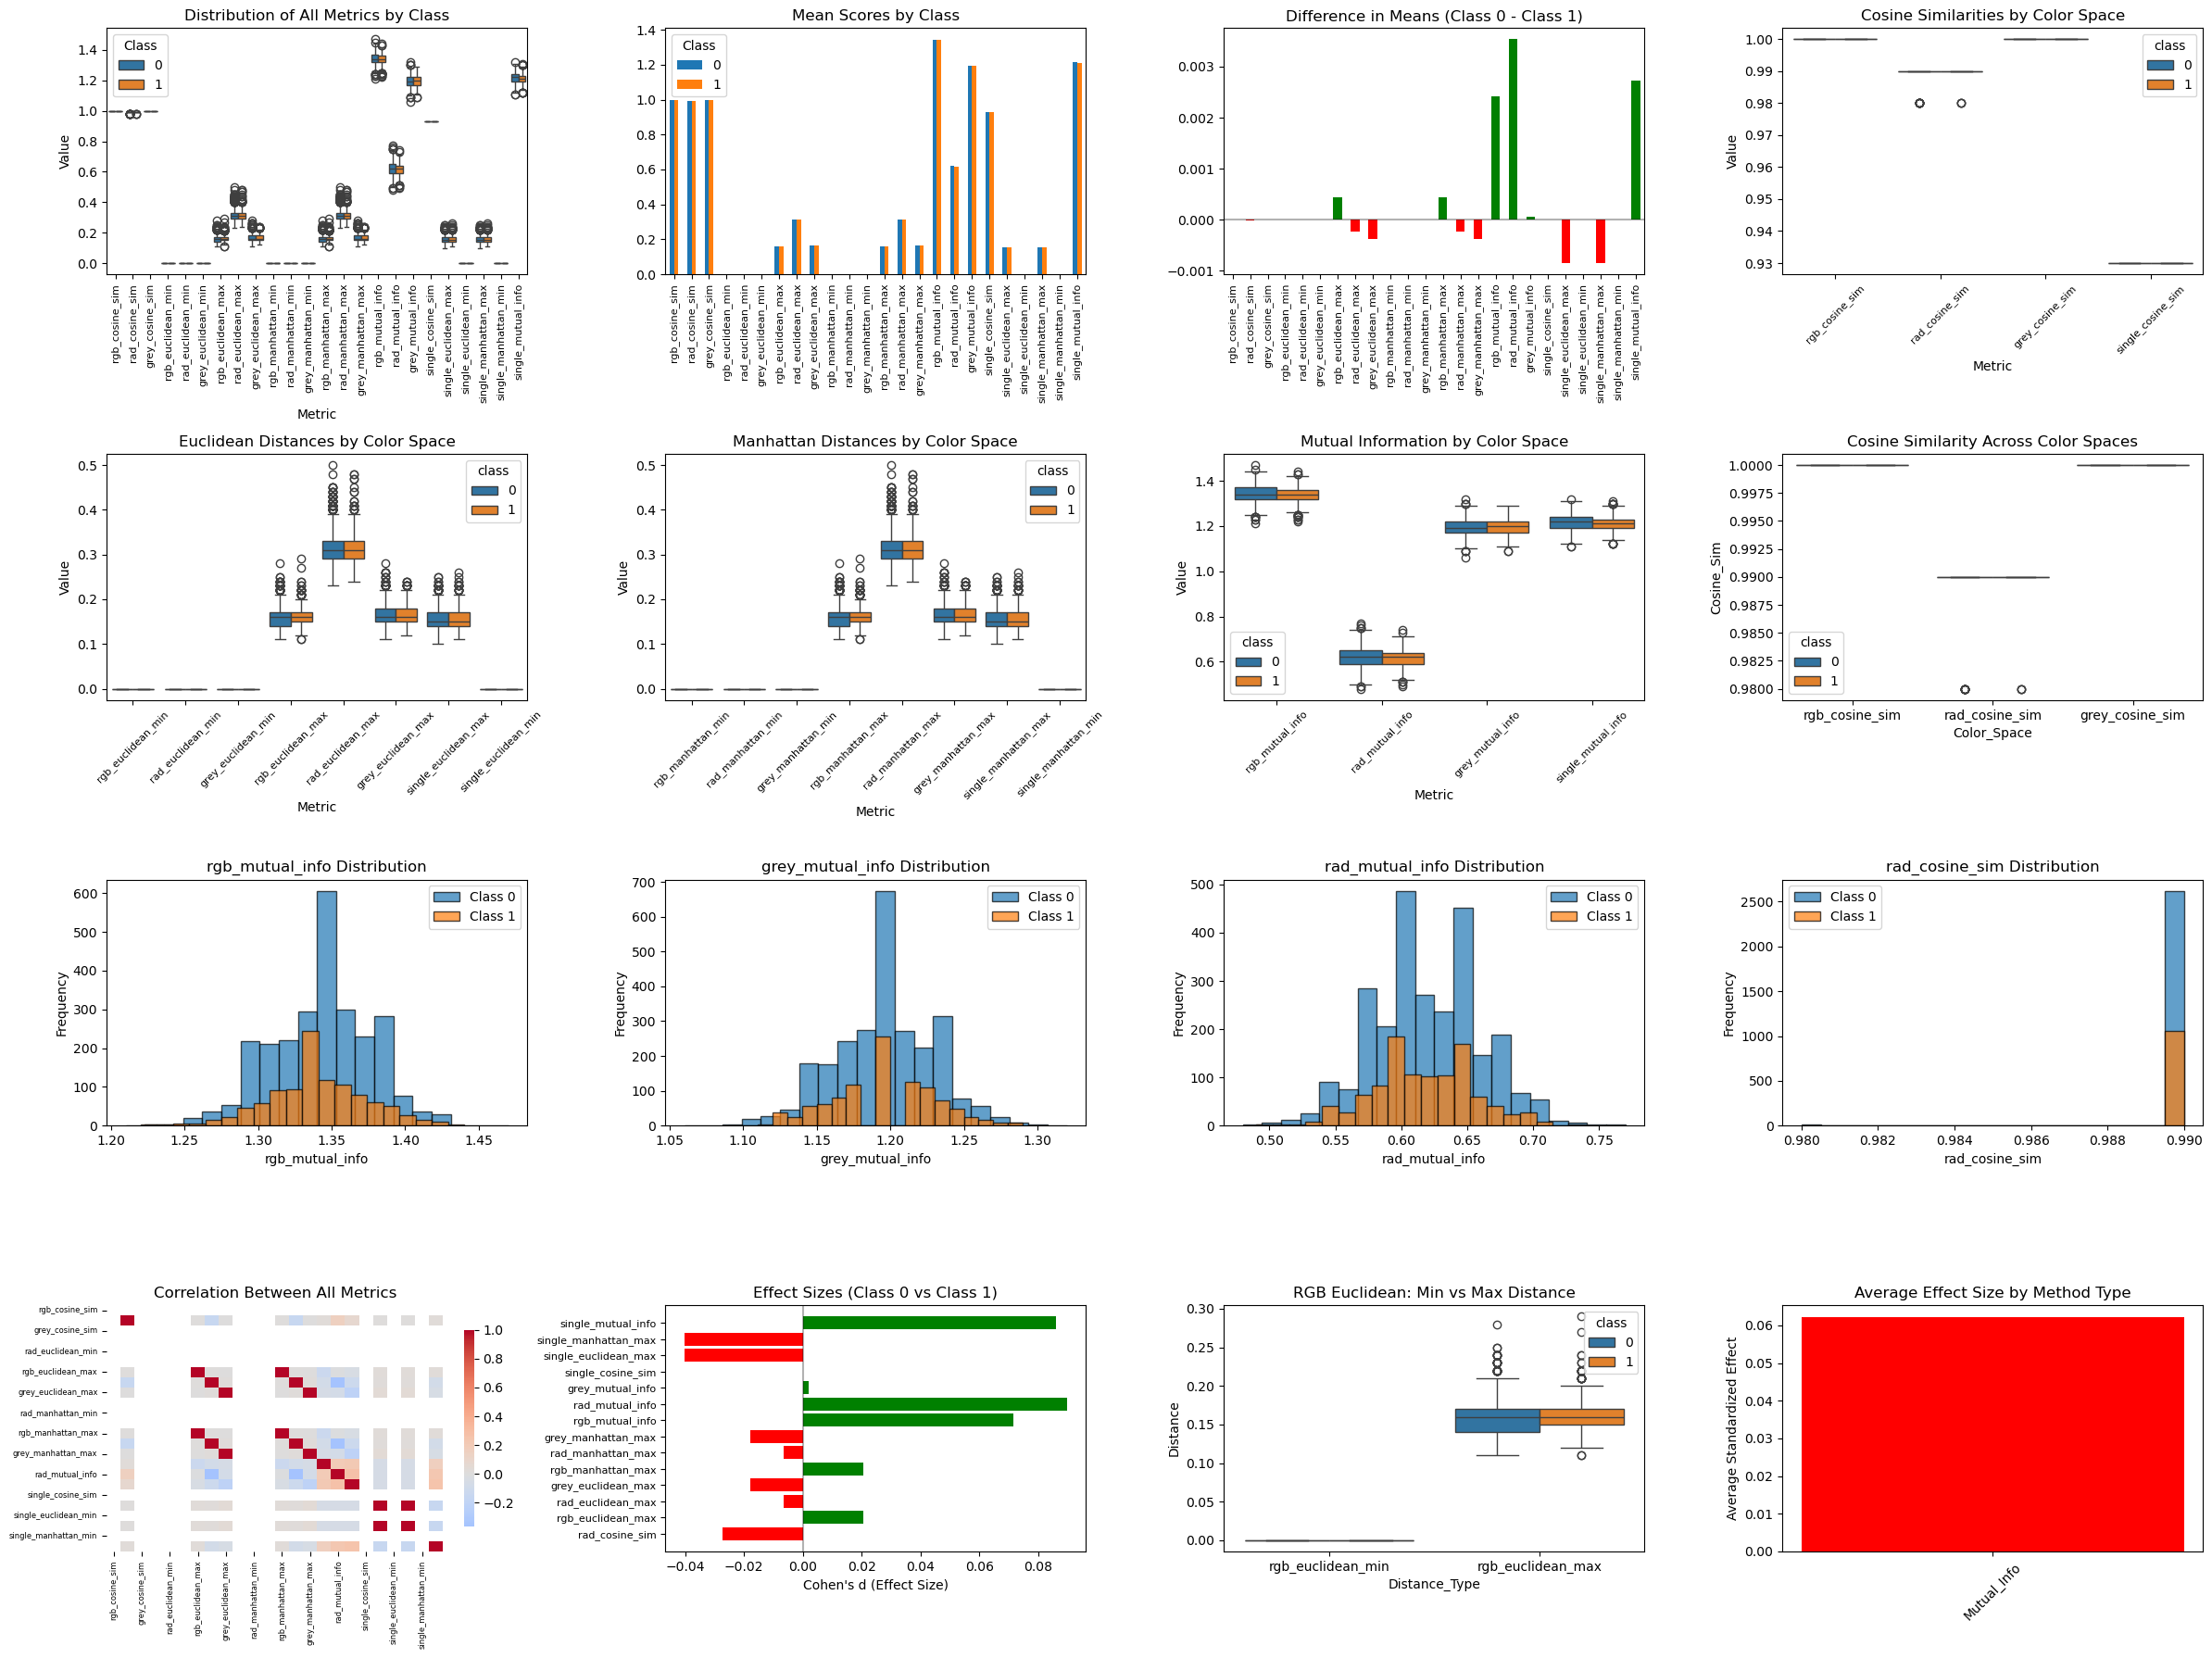

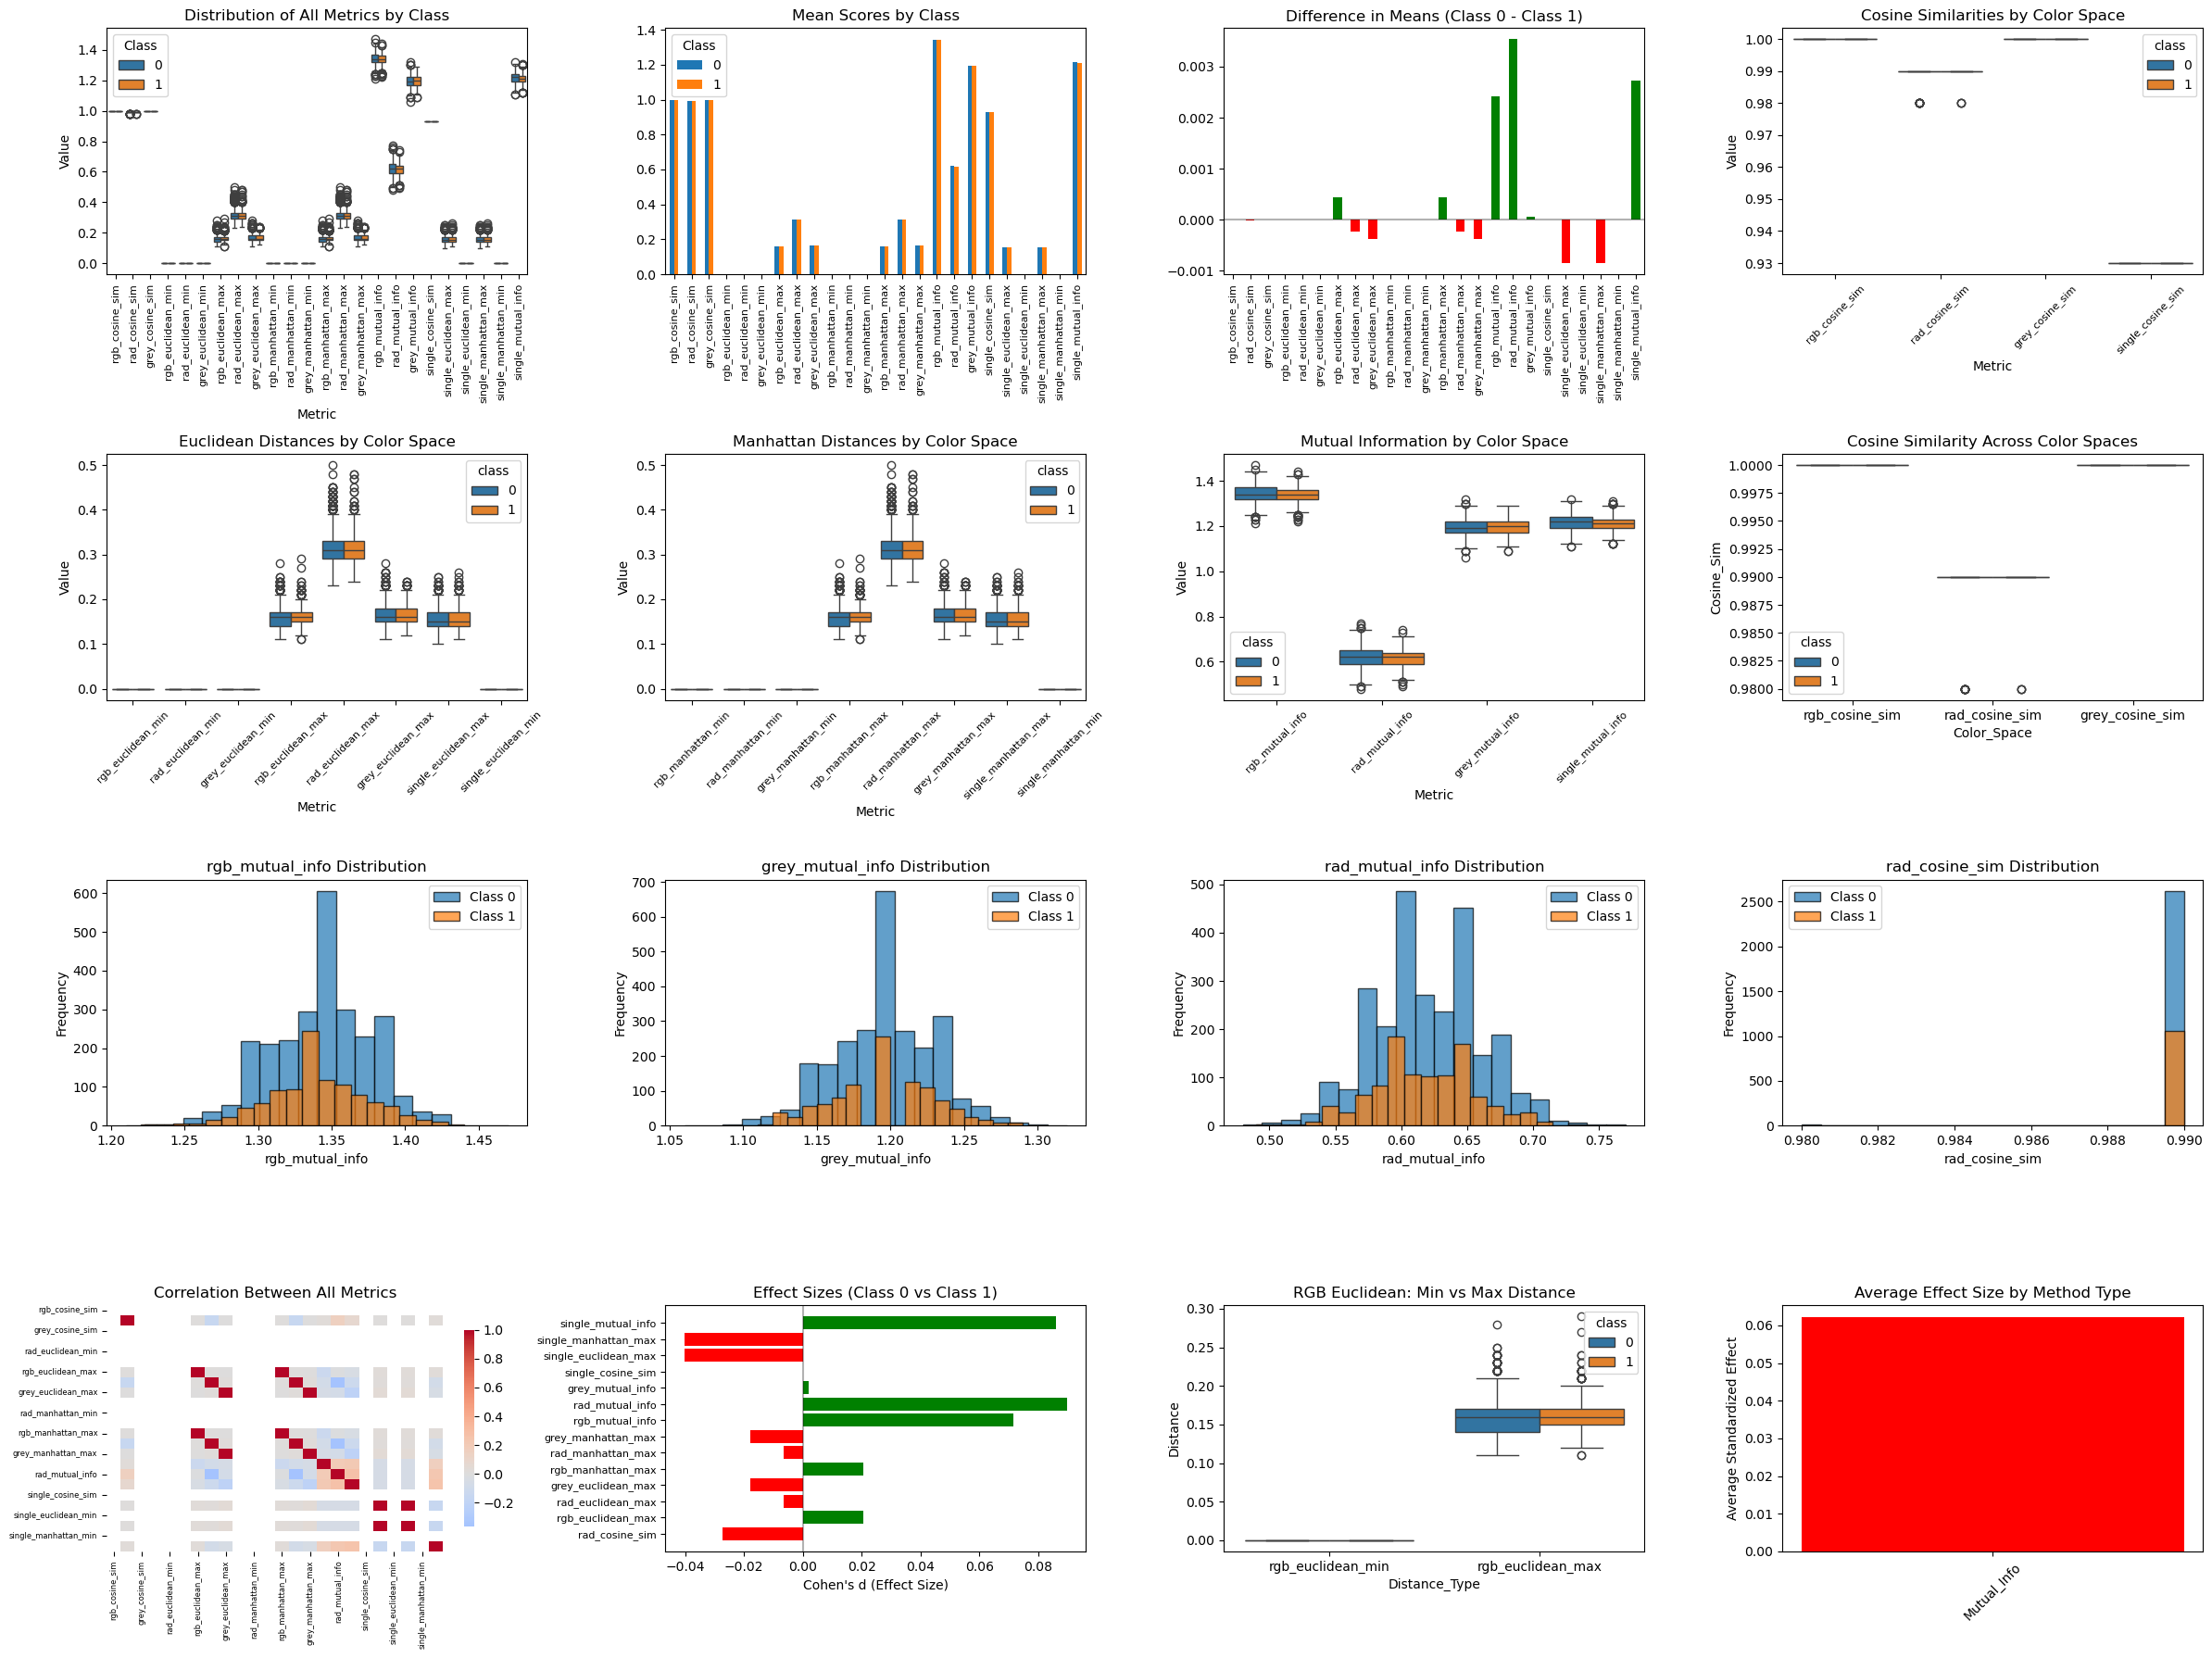

In [156]:
analyze_distance_metrics(analyze_df)

In [157]:
results_df = statistical_analysis_distances(analyze_df,True)

DISTANCE/SIMILARITY METRICS STATISTICAL ANALYSIS

==================== COSINE SIMILARITY ====================

--- RGB Model ---

RGB COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean = 1.0000, Std = 0.0000, N = 1060
Difference: 0.0000

Statistical Test: Welch's t-test (unequal variances)
Test Statistic: nan
P-value: nan
Significant: No (α = 0.05)
Cohen's d: 0.0000 (Small effect)

--- RAD Model ---

RAD COSINE SIM
------------------------------------------------------------
Class 0: Mean = 0.9900, Std = 0.0007, N = 2628
Class 1: Mean = 0.9900, Std = 0.0005, N = 1060
Difference: -0.0000

Statistical Test: Mann-Whitney U test (non-parametric)
Test Statistic: 1390422.0000
P-value: 0.453619
Significant: No (α = 0.05)
Cohen's d: -0.0273 (Small effect)

--- Grey Model ---

GREY COSINE SIM
------------------------------------------------------------
Class 0: Mean = 1.0000, Std = 0.0000, N = 2628
Class 1: Mean =

In [158]:
generate_distance_report(analyze_df, results_df)


DISTANCE METRICS ANALYSIS SUMMARY REPORT
Total distance/similarity metrics analyzed: 24
Metrics showing significant differences: 3
Percentage of metrics with significant differences: 12.5%

ANALYSIS BY METHOD TYPE

Cosine Similarity:
  • Significant: 0/4 metrics
  • Average |Effect Size|: 0.007
    - RGB Model: ✗ Cohen's d = 0.000 ↓
    - RAD Model: ✗ Cohen's d = -0.027 ↓
    - Grey Model: ✗ Cohen's d = 0.000 ↓
    - Single Model: ✗ Cohen's d = 0.000 ↓

Euclidean Distance:
  • Significant: 0/8 metrics
  • Average |Effect Size|: 0.011
    - RGB Model (Min): ✗ Cohen's d = 0.000 ↓
    - RGB Model (Max): ✗ Cohen's d = 0.021 ↑
    - RAD Model (Min): ✗ Cohen's d = 0.000 ↓
    - RAD Model (Max): ✗ Cohen's d = -0.007 ↓
    - Grey Model (Min): ✗ Cohen's d = 0.000 ↓
    - Grey Model (Max): ✗ Cohen's d = -0.018 ↓
    - Single Model (Min): ✗ Cohen's d = 0.000 ↓
    - Single Model (Max): ✗ Cohen's d = -0.040 ↓

Manhattan Distance:
  • Significant: 0/8 metrics
  • Average |Effect Size|: 0.011
    -